In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments


def select_data(df):
#     return df[['acc_x', 'acc_y', 'acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len)
        target_segs = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [9]:
datapoint_per_second = 20
duration = 2
chunk_size = 7
seq_len = 21
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [12]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

388 370 364


In [13]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-1.46666997e+00,  3.02090550e-02,  1.02965024e+00, -4.78252917e-01,
        -3.82730037e-01,  1.22318631e-02,  8.28334045e+00, -1.33542404e+01,
         4.17045288e+01,  1.67575811e+09]),
 array([ 1.25826234e-01, -1.58992693e+00, -1.53935553e+00, -6.28472567e-02,
         3.16822752e-02,  2.58390278e-01, -3.71943283e+01,  1.32483292e+00,
        -2.49790649e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
# class ClassDataset(Dataset):
#     def __init__(self, data, label):
#         self.data = data
#         self.label = label

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.label[idx]

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(9, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.fe_layer = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )

        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
#         self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
        self.fe_last = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 9),
        )
        
    def forward(self, source_data):
        
        ### step 1
        h_data = self.fe_layer(source_data)
        h_data = h_data.reshape((len(source_data), self.chunk_size, -1))
        
        ### step 2
        h_data = self.pos_encoder(h_data)
        z = self.encoder(h_data)
        
        ### step 3
        pred_data = z.reshape((len(source_data), self.chunk_size, self.seq_len, -1))
        pred_data = self.fe_last(pred_data)
        
        return pred_data
        

In [19]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [20]:
def generator_loss(pred_data, target_data):
    lin_acc_loss = mse_loss(pred_data[:, :, :, 0:3], target_data[:, :, :, 0:3])
    gro_loss = mse_loss(pred_data[:, :, :, 3:6], target_data[:, :, :, 3:6])
    mag_loss = mse_loss(pred_data[:, :, :, 6:9], target_data[:, :, :, 6:9])

    total_loss = lin_acc_loss + gro_loss + mag_loss
    return total_loss, lin_acc_loss, gro_loss, mag_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [21]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.8)
pocket_half = int(len(pocket_pair_data) * 0.8)
swing_half = int(len(swing_pair_data) * 0.8)

train_data = swing_pair_data[:swing_half] #+ front_pocket_pair_data[:front_pocket_half] + pocket_pair_data[:pocket_half]
valid_data = swing_pair_data[swing_half:] #+ front_pocket_pair_data[front_pocket_half:] + pocket_pair_data[pocket_half:]

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=256)

In [22]:
batch = next(iter(train_loader))

In [23]:
# batch

In [24]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()

In [25]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [26]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [27]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    lin_acc_losses = []
    gro_losses = []
    mag_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data[:, :, :, 0:9].to(device)
        target_data = target_data[:, :, :, 0:9].to(device)

        # generate mag
        predict_data = model(source_data)
        
        # generator loss
        gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        lin_acc_losses.append(lin_acc_loss.item())
        gro_losses.append(gro_loss.item())
        mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_data[0, :, :, 6:9].detach().cpu().numpy(), target_data[0, :, :, 6:9].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(lin_acc_losses), np.mean(gro_losses), np.mean(mag_losses)

In [28]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    lin_acc_losses = []
    gro_losses = []
    mag_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data[:, :, :, 0:9].to(device)
            target_data = target_data[:, :, :, 0:9].to(device)

            # generate mag
            predict_data = model(source_data)

            # generator loss
            gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)

            # record loss
            g_losses.append(gen_loss.item())
            lin_acc_losses.append(lin_acc_loss.item())
            gro_losses.append(gro_loss.item())
            mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_data[0, :, :, 6:9].detach().cpu().numpy(), target_data[0, :, :, 6:9].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(lin_acc_losses), np.mean(gro_losses), np.mean(mag_losses)

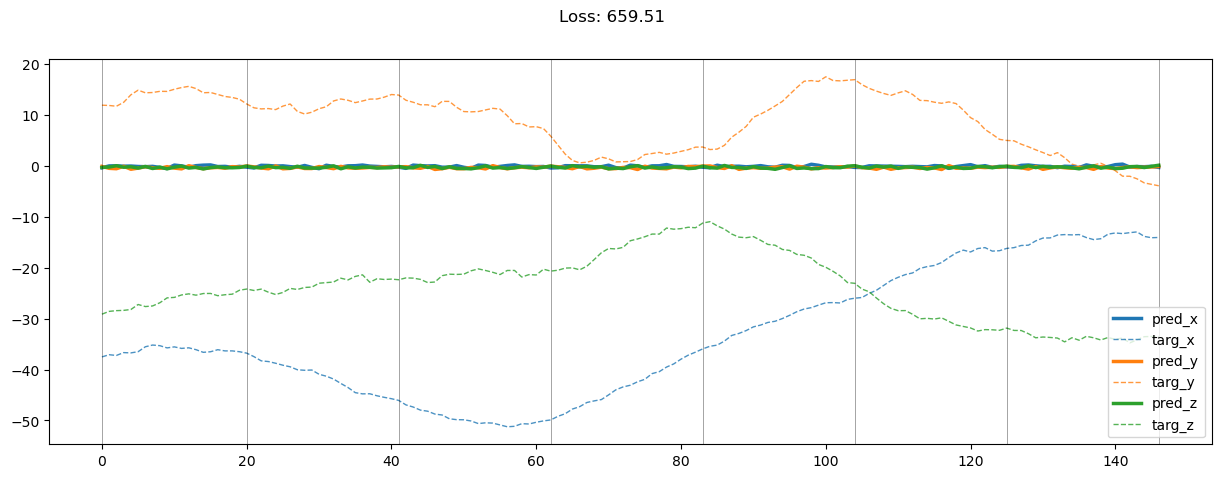

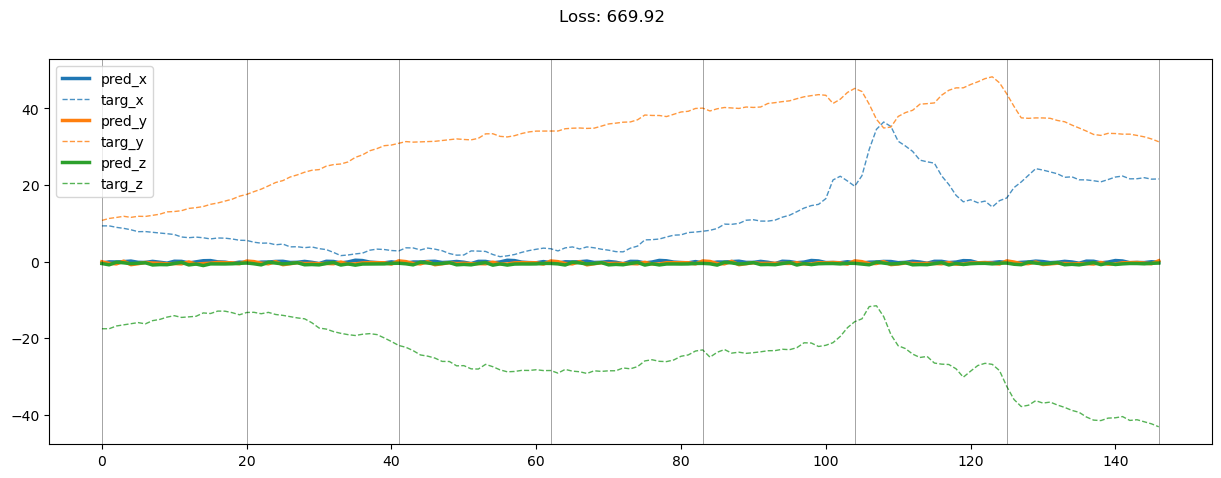

00019: train loss:  643.733, lin acc loss:  1.948, gro loss:  0.200, mag loss:  641.585
       valid loss:  652.222, lin acc loss:  1.392, gro loss:  0.147, mag loss:  650.683
00039: train loss:  628.217, lin acc loss:  1.914, gro loss:  0.200, mag loss:  626.104
       valid loss:  641.982, lin acc loss:  1.332, gro loss:  0.137, mag loss:  640.513
00059: train loss:  638.160, lin acc loss:  1.839, gro loss:  0.184, mag loss:  636.137
       valid loss:  635.122, lin acc loss:  1.288, gro loss:  0.133, mag loss:  633.701
00079: train loss:  631.802, lin acc loss:  1.844, gro loss:  0.181, mag loss:  629.777
       valid loss:  629.303, lin acc loss:  1.277, gro loss:  0.134, mag loss:  627.893
00099: train loss:  633.368, lin acc loss:  1.896, gro loss:  0.195, mag loss:  631.276
       valid loss:  623.478, lin acc loss:  1.255, gro loss:  0.127, mag loss:  622.096
00119: train loss:  620.802, lin acc loss:  1.861, gro loss:  0.201, mag loss:  618.740
       valid loss:  617.545, lin

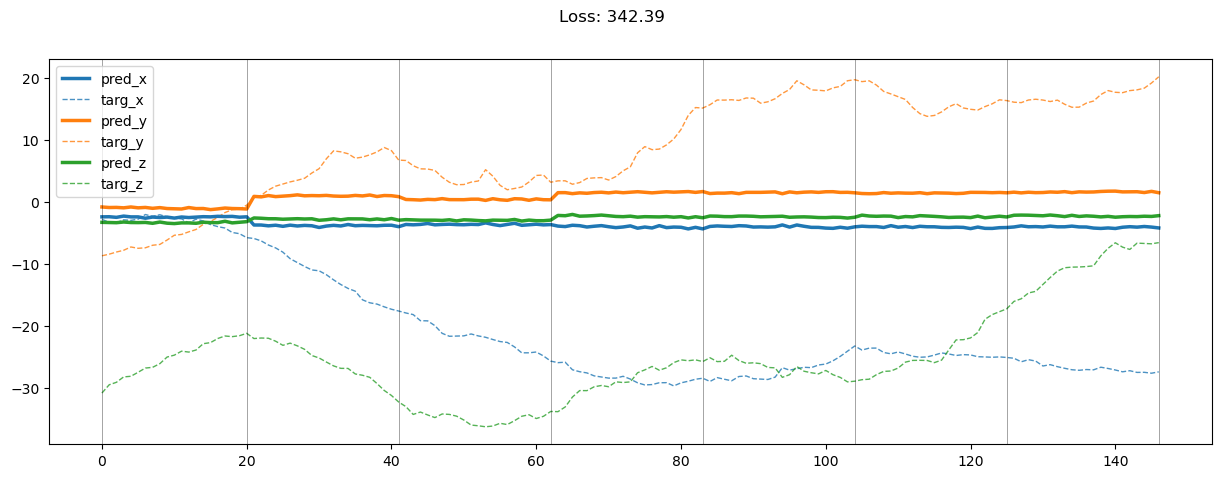

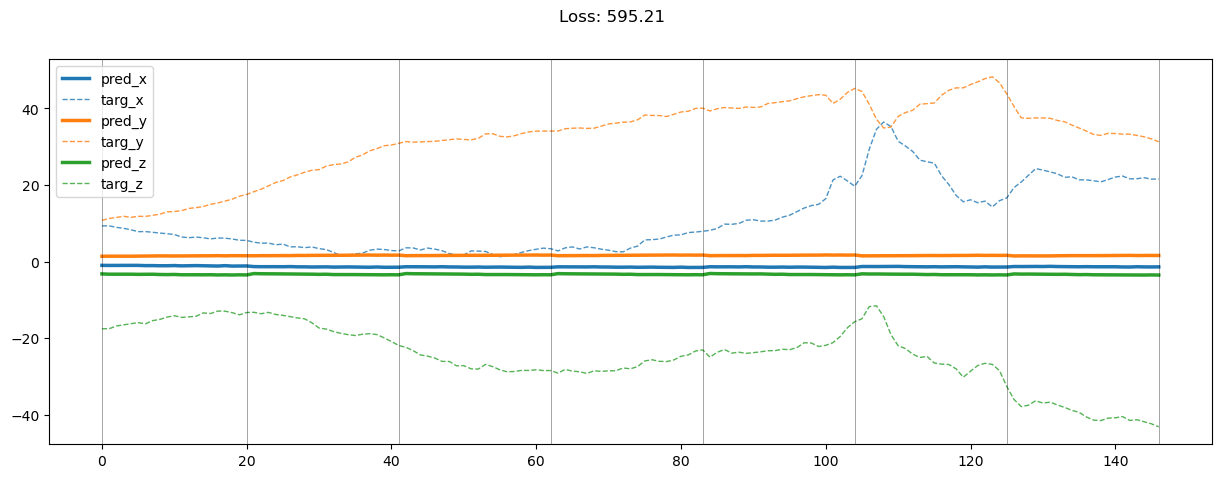

00199: train loss:  577.394, lin acc loss:  1.683, gro loss:  0.193, mag loss:  575.518
       valid loss:  590.292, lin acc loss:  1.110, gro loss:  0.130, mag loss:  589.052
00219: train loss:  565.479, lin acc loss:  1.644, gro loss:  0.192, mag loss:  563.643
       valid loss:  582.282, lin acc loss:  1.069, gro loss:  0.133, mag loss:  581.080
00239: train loss:  571.505, lin acc loss:  1.588, gro loss:  0.185, mag loss:  569.732
       valid loss:  574.336, lin acc loss:  1.014, gro loss:  0.133, mag loss:  573.190
00259: train loss:  557.878, lin acc loss:  1.554, gro loss:  0.184, mag loss:  556.140
       valid loss:  565.686, lin acc loss:  1.000, gro loss:  0.123, mag loss:  564.563
00279: train loss:  541.160, lin acc loss:  1.539, gro loss:  0.179, mag loss:  539.441
       valid loss:  556.911, lin acc loss:  0.943, gro loss:  0.122, mag loss:  555.847
00299: train loss:  529.980, lin acc loss:  1.400, gro loss:  0.171, mag loss:  528.409
       valid loss:  548.173, lin

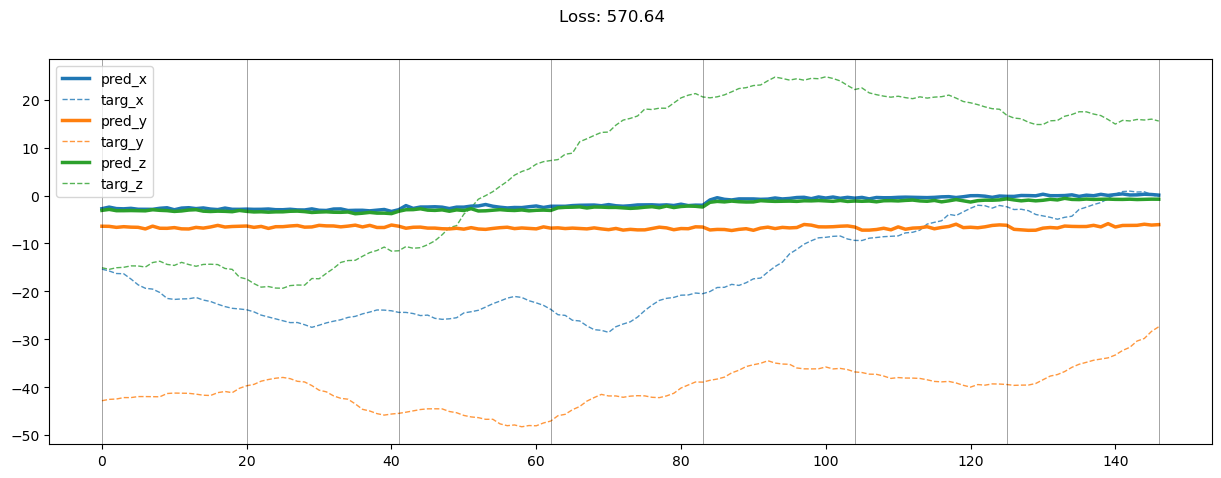

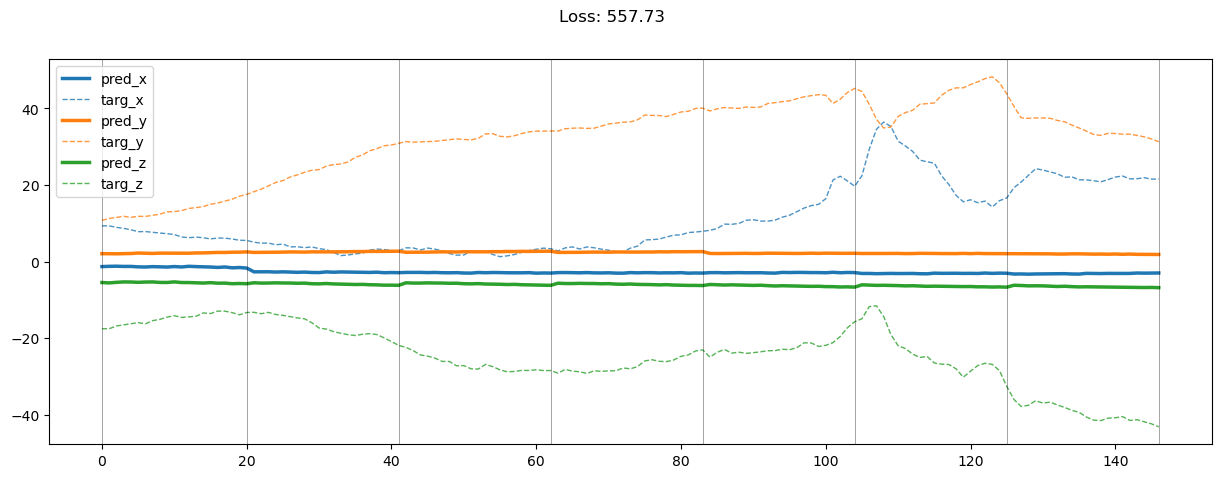

00399: train loss:  471.830, lin acc loss:  1.330, gro loss:  0.152, mag loss:  470.349
       valid loss:  496.809, lin acc loss:  0.753, gro loss:  0.097, mag loss:  495.959
00419: train loss:  465.593, lin acc loss:  1.343, gro loss:  0.161, mag loss:  464.089
       valid loss:  485.580, lin acc loss:  0.733, gro loss:  0.095, mag loss:  484.752
00439: train loss:  456.959, lin acc loss:  1.326, gro loss:  0.160, mag loss:  455.474
       valid loss:  474.599, lin acc loss:  0.718, gro loss:  0.094, mag loss:  473.787
00459: train loss:  442.482, lin acc loss:  1.335, gro loss:  0.151, mag loss:  440.996
       valid loss:  462.801, lin acc loss:  0.715, gro loss:  0.094, mag loss:  461.991
00479: train loss:  446.996, lin acc loss:  1.205, gro loss:  0.139, mag loss:  445.652
       valid loss:  451.217, lin acc loss:  0.705, gro loss:  0.091, mag loss:  450.422
00499: train loss:  449.098, lin acc loss:  1.297, gro loss:  0.144, mag loss:  447.658
       valid loss:  439.517, lin

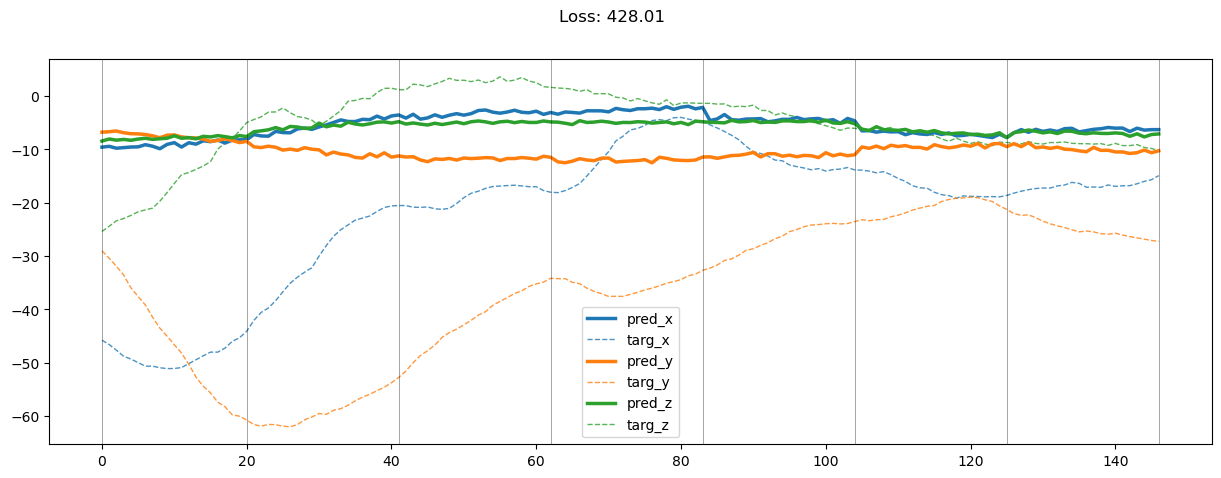

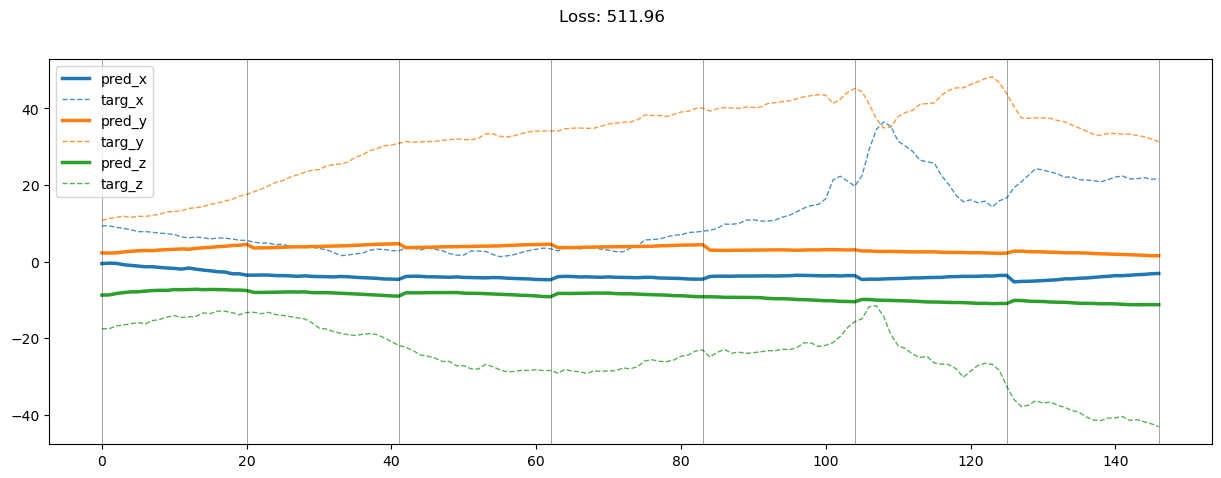

00599: train loss:  403.197, lin acc loss:  1.323, gro loss:  0.142, mag loss:  401.733
       valid loss:  382.171, lin acc loss:  0.675, gro loss:  0.079, mag loss:  381.417
00619: train loss:  357.535, lin acc loss:  1.295, gro loss:  0.141, mag loss:  356.098
       valid loss:  371.278, lin acc loss:  0.680, gro loss:  0.080, mag loss:  370.517
00639: train loss:  337.470, lin acc loss:  1.264, gro loss:  0.140, mag loss:  336.065
       valid loss:  359.779, lin acc loss:  0.674, gro loss:  0.077, mag loss:  359.028
00659: train loss:  337.036, lin acc loss:  1.230, gro loss:  0.134, mag loss:  335.672
       valid loss:  349.638, lin acc loss:  0.678, gro loss:  0.079, mag loss:  348.881
00679: train loss:  316.026, lin acc loss:  1.269, gro loss:  0.128, mag loss:  314.628
       valid loss:  339.377, lin acc loss:  0.681, gro loss:  0.080, mag loss:  338.616
00699: train loss:  300.617, lin acc loss:  1.322, gro loss:  0.136, mag loss:  299.159
       valid loss:  327.952, lin

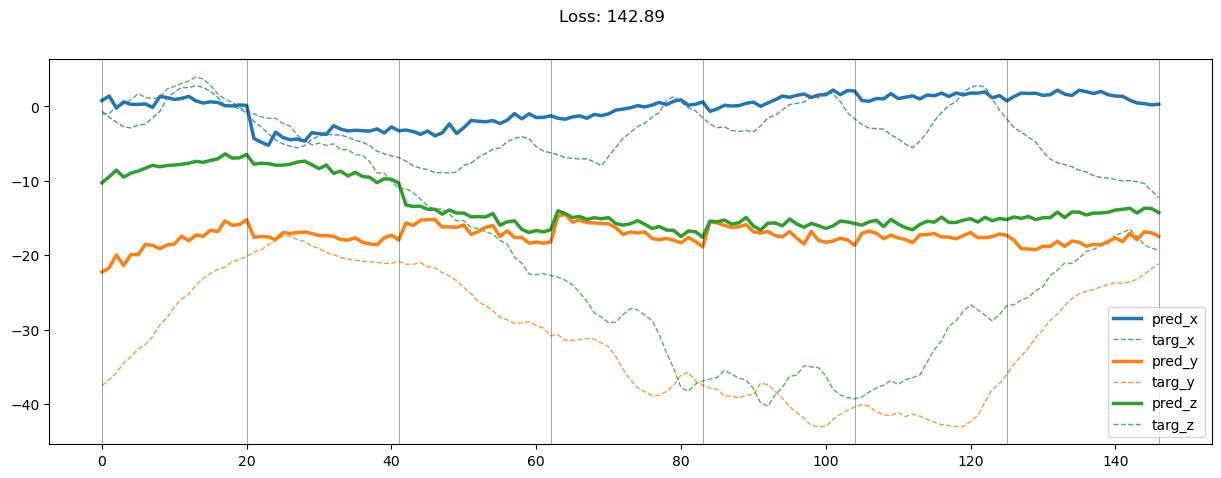

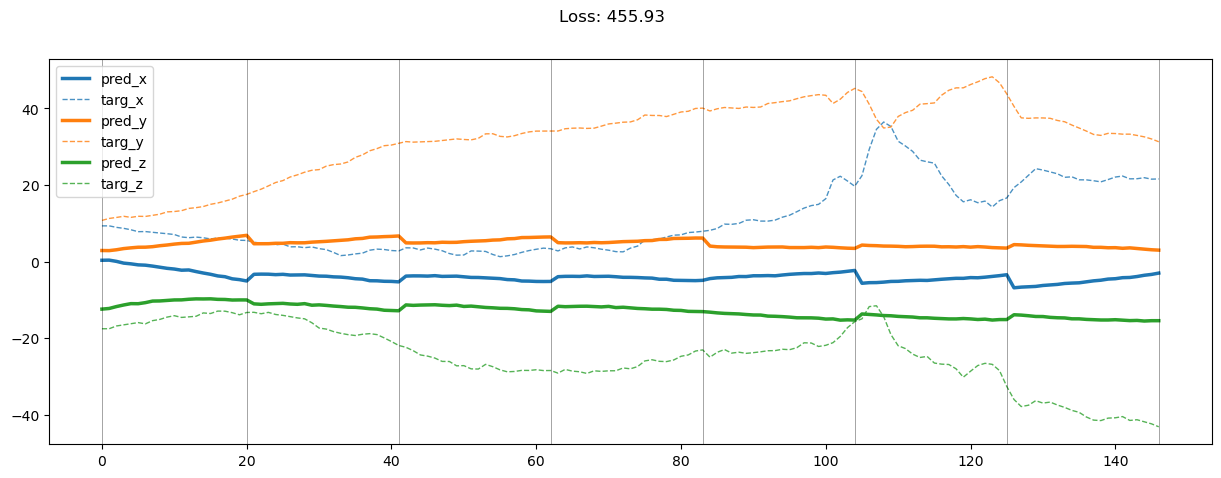

00799: train loss:  252.183, lin acc loss:  1.306, gro loss:  0.132, mag loss:  250.745
       valid loss:  279.349, lin acc loss:  0.686, gro loss:  0.079, mag loss:  278.584
00819: train loss:  248.937, lin acc loss:  1.275, gro loss:  0.144, mag loss:  247.517
       valid loss:  270.894, lin acc loss:  0.687, gro loss:  0.078, mag loss:  270.128
00839: train loss:  234.968, lin acc loss:  1.319, gro loss:  0.142, mag loss:  233.506
       valid loss:  262.537, lin acc loss:  0.685, gro loss:  0.078, mag loss:  261.774
00859: train loss:  222.390, lin acc loss:  1.324, gro loss:  0.131, mag loss:  220.935
       valid loss:  254.575, lin acc loss:  0.689, gro loss:  0.079, mag loss:  253.807
00879: train loss:  228.934, lin acc loss:  1.280, gro loss:  0.133, mag loss:  227.521
       valid loss:  246.493, lin acc loss:  0.688, gro loss:  0.078, mag loss:  245.726
00899: train loss:  211.395, lin acc loss:  1.308, gro loss:  0.133, mag loss:  209.954
       valid loss:  238.580, lin

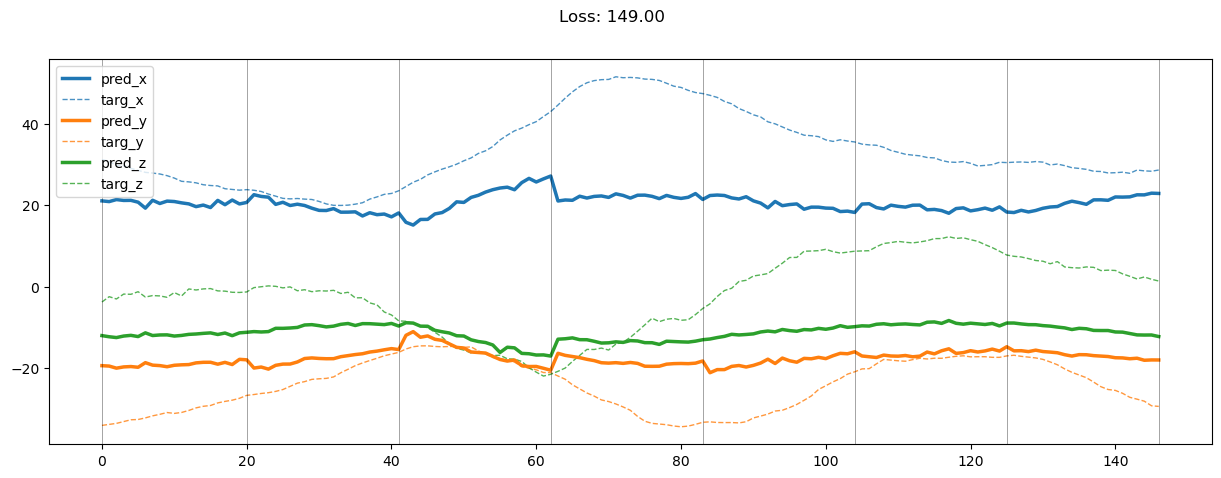

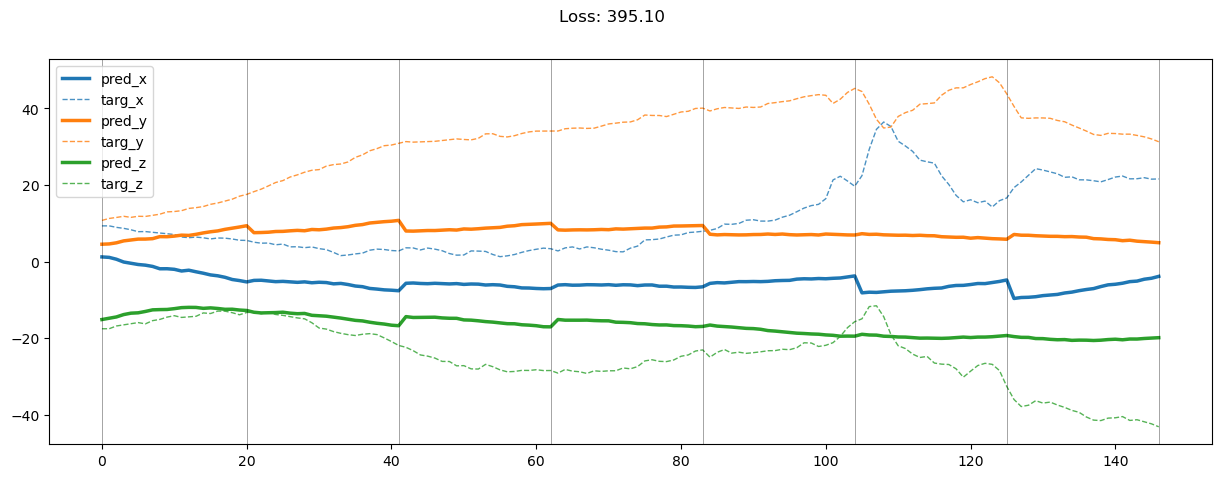

00999: train loss:  171.444, lin acc loss:  1.344, gro loss:  0.136, mag loss:  169.964
       valid loss:  204.398, lin acc loss:  0.687, gro loss:  0.078, mag loss:  203.633
01019: train loss:  172.294, lin acc loss:  1.253, gro loss:  0.129, mag loss:  170.912
       valid loss:  198.574, lin acc loss:  0.690, gro loss:  0.078, mag loss:  197.806
01039: train loss:  175.409, lin acc loss:  1.243, gro loss:  0.134, mag loss:  174.032
       valid loss:  192.966, lin acc loss:  0.691, gro loss:  0.079, mag loss:  192.196
01059: train loss:  149.823, lin acc loss:  1.250, gro loss:  0.138, mag loss:  148.435
       valid loss:  186.671, lin acc loss:  0.691, gro loss:  0.079, mag loss:  185.900
01079: train loss:  169.092, lin acc loss:  1.279, gro loss:  0.138, mag loss:  167.674
       valid loss:  181.845, lin acc loss:  0.690, gro loss:  0.078, mag loss:  181.076
01099: train loss:  147.737, lin acc loss:  1.353, gro loss:  0.128, mag loss:  146.257
       valid loss:  176.875, lin

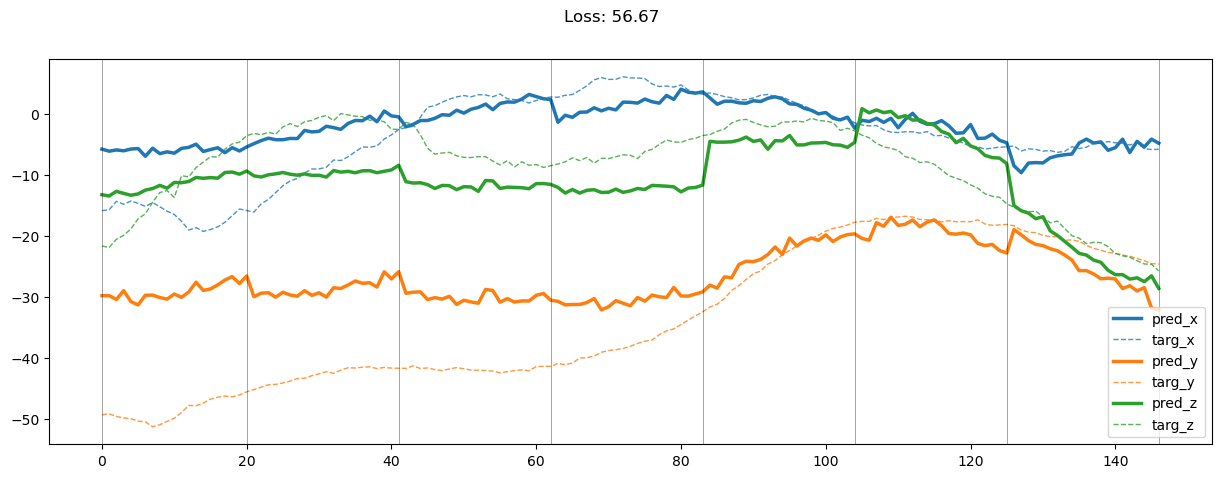

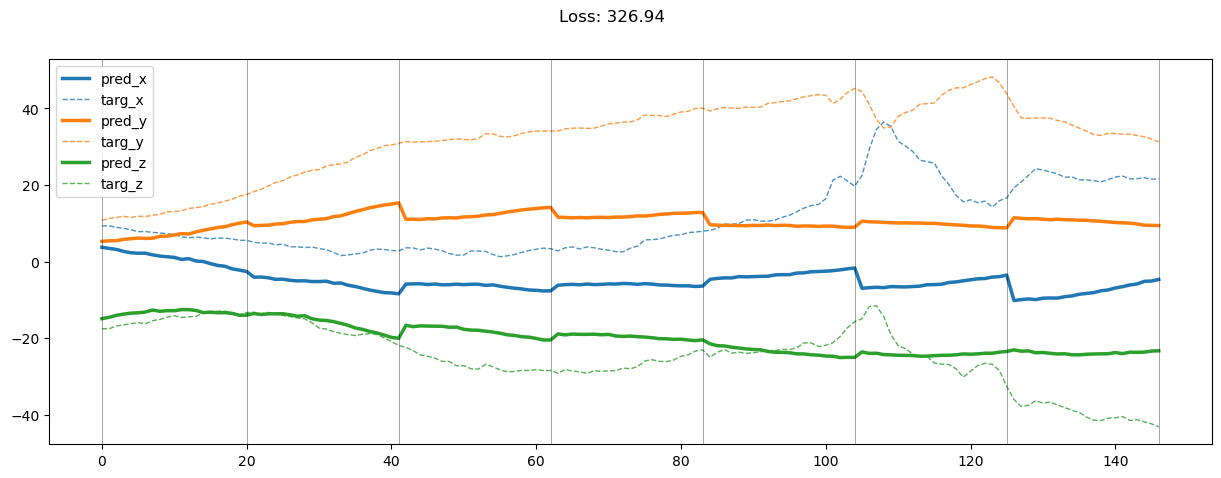

01199: train loss:  126.273, lin acc loss:  1.280, gro loss:  0.133, mag loss:  124.860
       valid loss:  155.518, lin acc loss:  0.689, gro loss:  0.078, mag loss:  154.751
01219: train loss:  114.768, lin acc loss:  1.299, gro loss:  0.135, mag loss:  113.335
       valid loss:  151.118, lin acc loss:  0.688, gro loss:  0.078, mag loss:  150.351
01239: train loss:  112.923, lin acc loss:  1.307, gro loss:  0.134, mag loss:  111.483
       valid loss:  148.130, lin acc loss:  0.689, gro loss:  0.079, mag loss:  147.362
01259: train loss:  107.964, lin acc loss:  1.227, gro loss:  0.130, mag loss:  106.607
       valid loss:  143.283, lin acc loss:  0.685, gro loss:  0.079, mag loss:  142.519
01279: train loss:  104.933, lin acc loss:  1.317, gro loss:  0.141, mag loss:  103.475
       valid loss:  139.309, lin acc loss:  0.690, gro loss:  0.081, mag loss:  138.538
01299: train loss:  94.913, lin acc loss:  1.323, gro loss:  0.137, mag loss:  93.452
       valid loss:  134.426, lin a

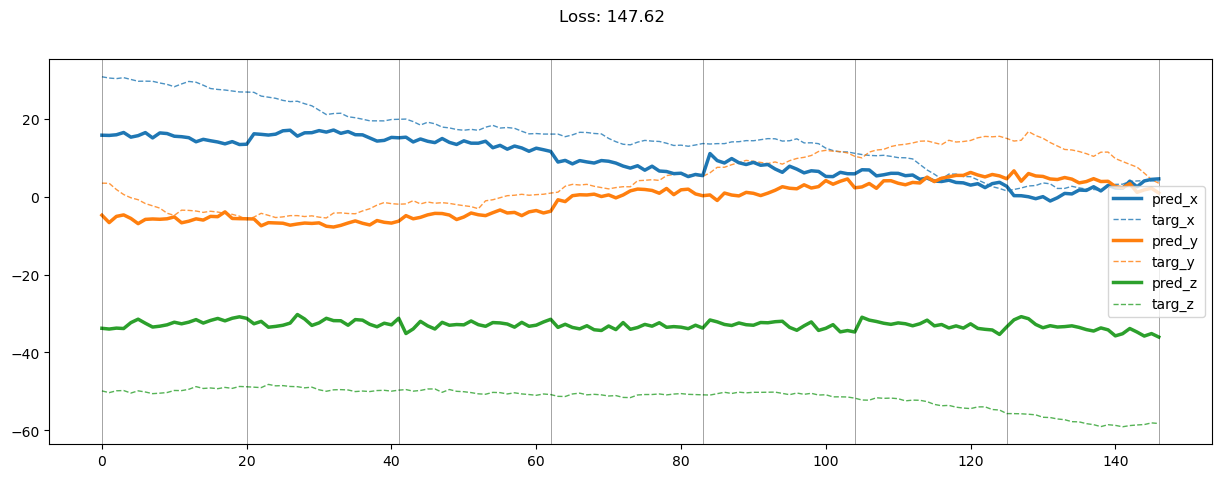

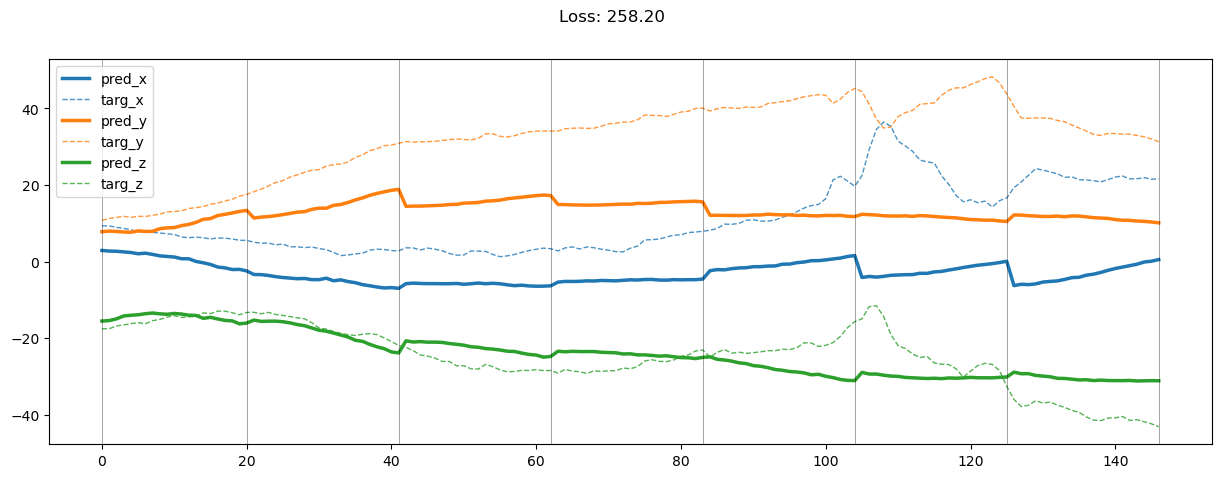

01399: train loss:  81.444, lin acc loss:  1.341, gro loss:  0.143, mag loss:  79.960
       valid loss:  117.984, lin acc loss:  0.680, gro loss:  0.080, mag loss:  117.224
01419: train loss:  75.187, lin acc loss:  1.287, gro loss:  0.143, mag loss:  73.758
       valid loss:  115.969, lin acc loss:  0.681, gro loss:  0.080, mag loss:  115.208
01439: train loss:  77.000, lin acc loss:  1.302, gro loss:  0.127, mag loss:  75.571
       valid loss:  114.567, lin acc loss:  0.680, gro loss:  0.080, mag loss:  113.807
01459: train loss:  70.341, lin acc loss:  1.261, gro loss:  0.136, mag loss:  68.944
       valid loss:  111.603, lin acc loss:  0.678, gro loss:  0.079, mag loss:  110.846
01479: train loss:  69.882, lin acc loss:  1.285, gro loss:  0.139, mag loss:  68.458
       valid loss:  108.418, lin acc loss:  0.678, gro loss:  0.079, mag loss:  107.661
01499: train loss:  67.360, lin acc loss:  1.318, gro loss:  0.142, mag loss:  65.900
       valid loss:  110.274, lin acc loss:  

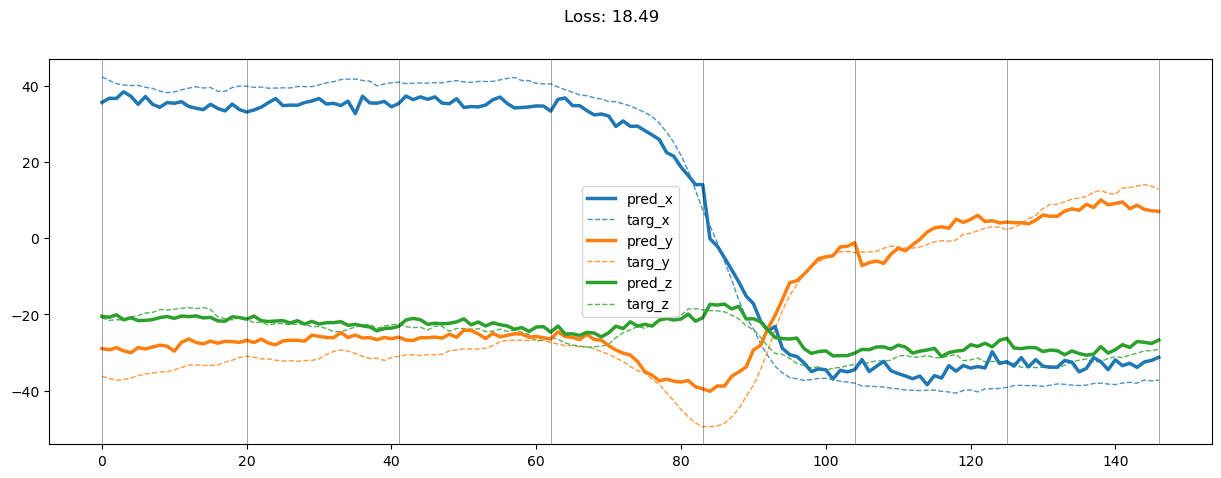

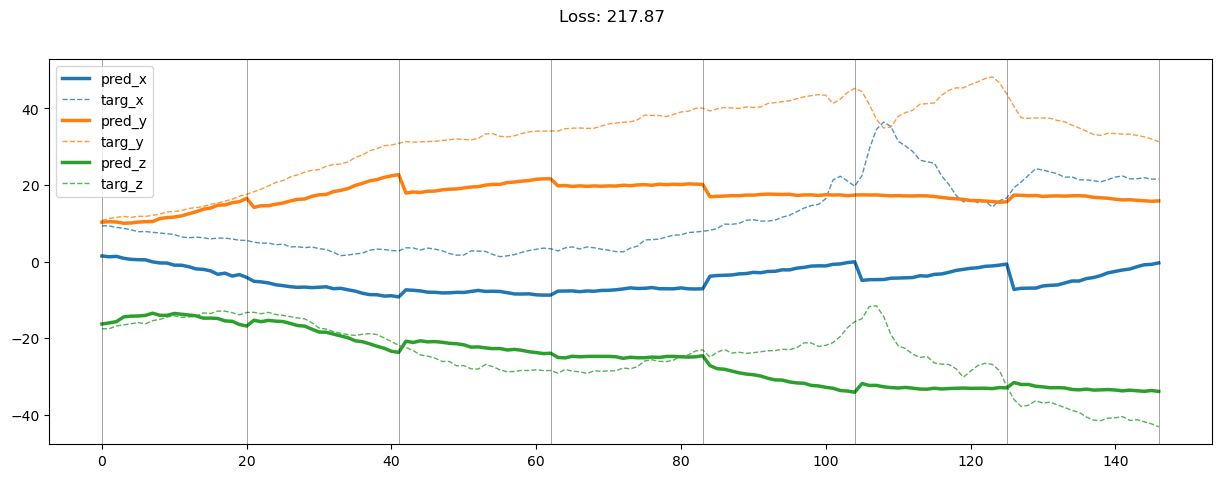

01599: train loss:  47.419, lin acc loss:  1.284, gro loss:  0.136, mag loss:  45.999
       valid loss:  98.634, lin acc loss:  0.673, gro loss:  0.078, mag loss:  97.883
01619: train loss:  48.321, lin acc loss:  1.337, gro loss:  0.145, mag loss:  46.840
       valid loss:  96.534, lin acc loss:  0.674, gro loss:  0.078, mag loss:  95.782
01639: train loss:  46.727, lin acc loss:  1.228, gro loss:  0.127, mag loss:  45.372
       valid loss:  95.266, lin acc loss:  0.674, gro loss:  0.078, mag loss:  94.514
01659: train loss:  44.218, lin acc loss:  1.237, gro loss:  0.127, mag loss:  42.855
       valid loss:  91.481, lin acc loss:  0.673, gro loss:  0.078, mag loss:  90.731
01679: train loss:  44.296, lin acc loss:  1.249, gro loss:  0.137, mag loss:  42.910
       valid loss:  92.689, lin acc loss:  0.673, gro loss:  0.078, mag loss:  91.939
01699: train loss:  48.818, lin acc loss:  1.323, gro loss:  0.144, mag loss:  47.350
       valid loss:  90.273, lin acc loss:  0.672, gro 

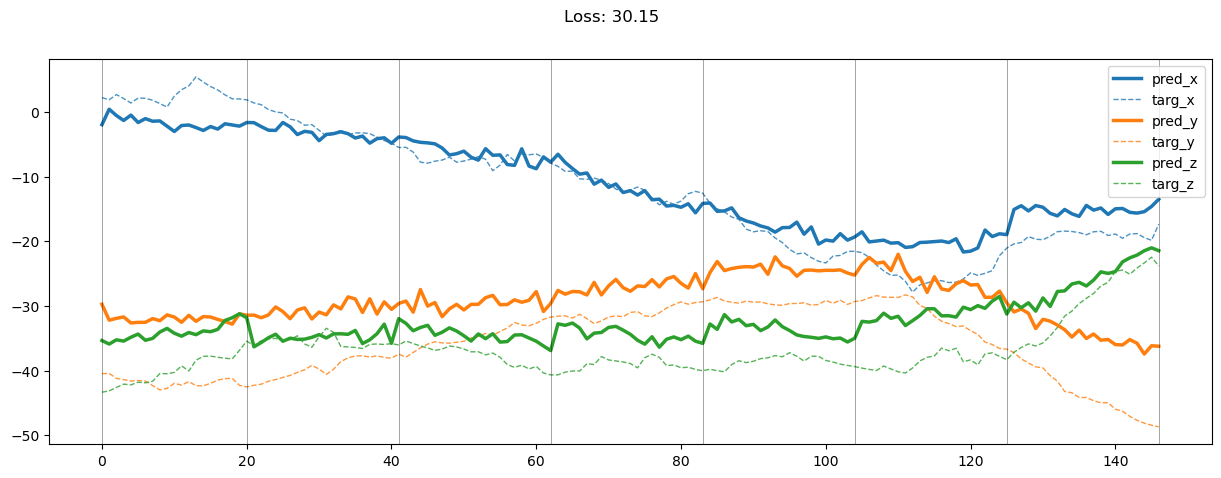

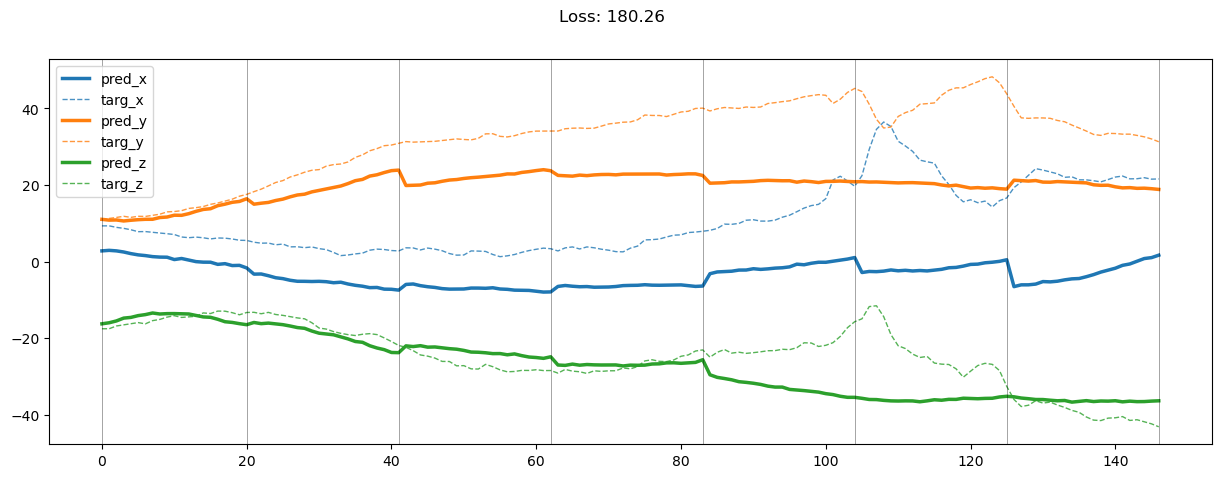

01799: train loss:  36.408, lin acc loss:  1.296, gro loss:  0.127, mag loss:  34.985
       valid loss:  85.199, lin acc loss:  0.671, gro loss:  0.077, mag loss:  84.451
01819: train loss:  33.862, lin acc loss:  1.262, gro loss:  0.128, mag loss:  32.473
       valid loss:  86.722, lin acc loss:  0.670, gro loss:  0.077, mag loss:  85.976
01839: train loss:  32.048, lin acc loss:  1.263, gro loss:  0.132, mag loss:  30.654
       valid loss:  84.302, lin acc loss:  0.669, gro loss:  0.077, mag loss:  83.556
01859: train loss:  31.730, lin acc loss:  1.288, gro loss:  0.136, mag loss:  30.306
       valid loss:  83.061, lin acc loss:  0.670, gro loss:  0.077, mag loss:  82.313
01879: train loss:  31.114, lin acc loss:  1.291, gro loss:  0.135, mag loss:  29.688
       valid loss:  82.555, lin acc loss:  0.669, gro loss:  0.077, mag loss:  81.808
01899: train loss:  29.991, lin acc loss:  1.337, gro loss:  0.139, mag loss:  28.516
       valid loss:  82.304, lin acc loss:  0.669, gro 

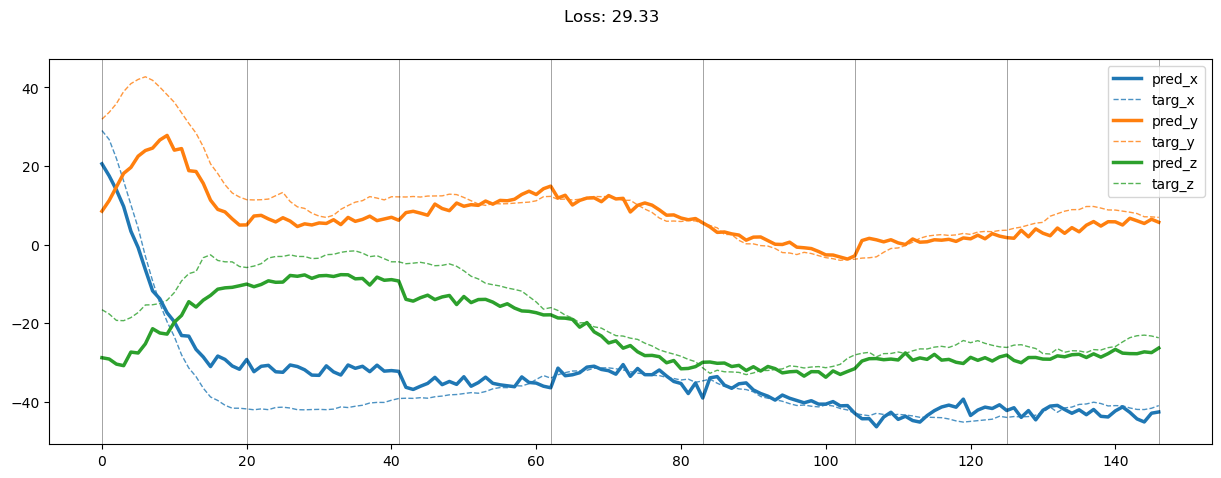

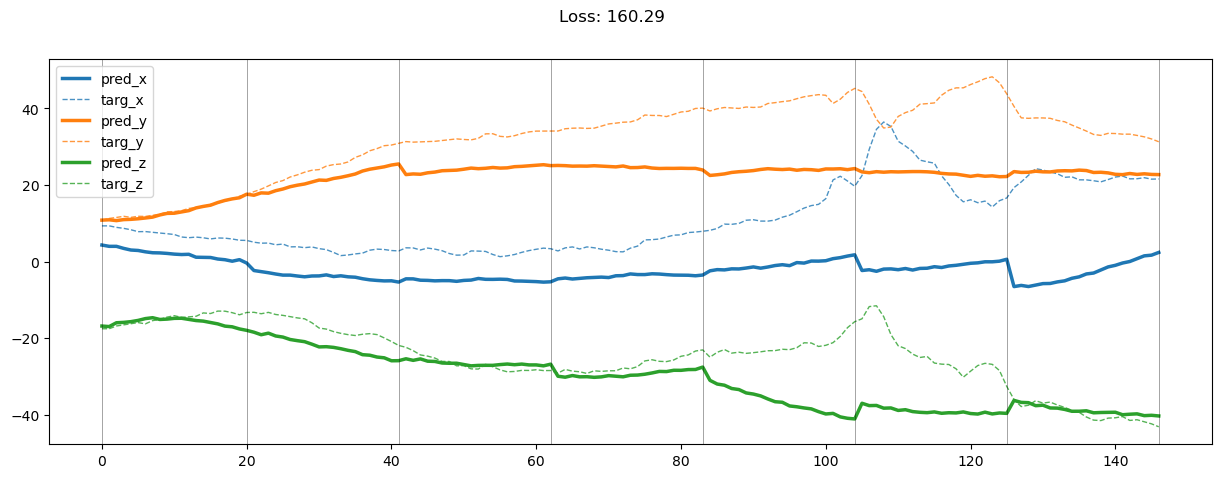

01999: train loss:  28.407, lin acc loss:  1.325, gro loss:  0.135, mag loss:  26.947
       valid loss:  83.294, lin acc loss:  0.667, gro loss:  0.076, mag loss:  82.551
02019: train loss:  28.027, lin acc loss:  1.309, gro loss:  0.143, mag loss:  26.575
       valid loss:  80.945, lin acc loss:  0.668, gro loss:  0.077, mag loss:  80.200
02039: train loss:  25.440, lin acc loss:  1.270, gro loss:  0.145, mag loss:  24.024
       valid loss:  79.218, lin acc loss:  0.667, gro loss:  0.076, mag loss:  78.475
02059: train loss:  23.505, lin acc loss:  1.258, gro loss:  0.128, mag loss:  22.119
       valid loss:  82.787, lin acc loss:  0.667, gro loss:  0.076, mag loss:  82.044
02079: train loss:  19.092, lin acc loss:  1.331, gro loss:  0.130, mag loss:  17.630
       valid loss:  79.693, lin acc loss:  0.667, gro loss:  0.076, mag loss:  78.950
02099: train loss:  21.478, lin acc loss:  1.263, gro loss:  0.126, mag loss:  20.089
       valid loss:  78.832, lin acc loss:  0.667, gro 

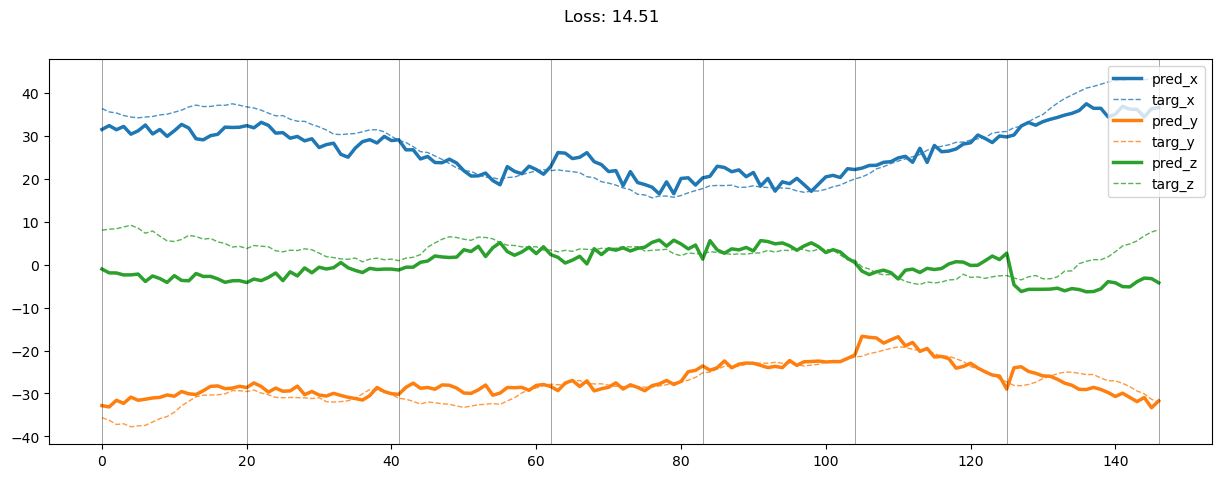

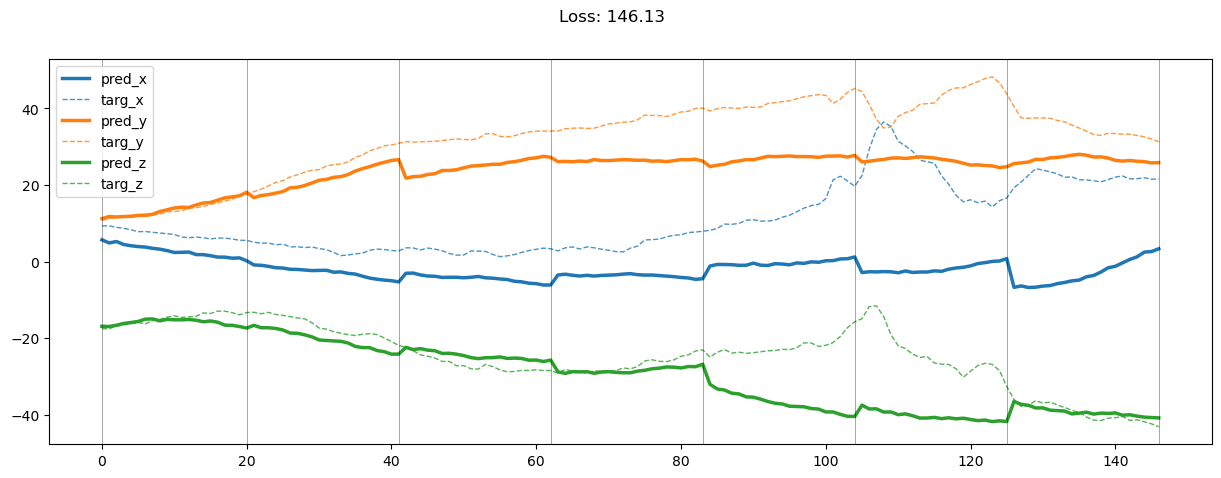

02199: train loss:  18.293, lin acc loss:  1.233, gro loss:  0.131, mag loss:  16.928
       valid loss:  75.308, lin acc loss:  0.666, gro loss:  0.076, mag loss:  74.566
02219: train loss:  20.766, lin acc loss:  1.244, gro loss:  0.126, mag loss:  19.396
       valid loss:  80.000, lin acc loss:  0.666, gro loss:  0.076, mag loss:  79.258
02239: train loss:  16.555, lin acc loss:  1.249, gro loss:  0.134, mag loss:  15.171
       valid loss:  80.821, lin acc loss:  0.666, gro loss:  0.076, mag loss:  80.080
02259: train loss:  20.089, lin acc loss:  1.303, gro loss:  0.144, mag loss:  18.642
       valid loss:  74.849, lin acc loss:  0.666, gro loss:  0.076, mag loss:  74.107
02279: train loss:  17.235, lin acc loss:  1.243, gro loss:  0.128, mag loss:  15.865
       valid loss:  74.586, lin acc loss:  0.666, gro loss:  0.076, mag loss:  73.844
02299: train loss:  17.469, lin acc loss:  1.284, gro loss:  0.140, mag loss:  16.045
       valid loss:  78.008, lin acc loss:  0.666, gro 

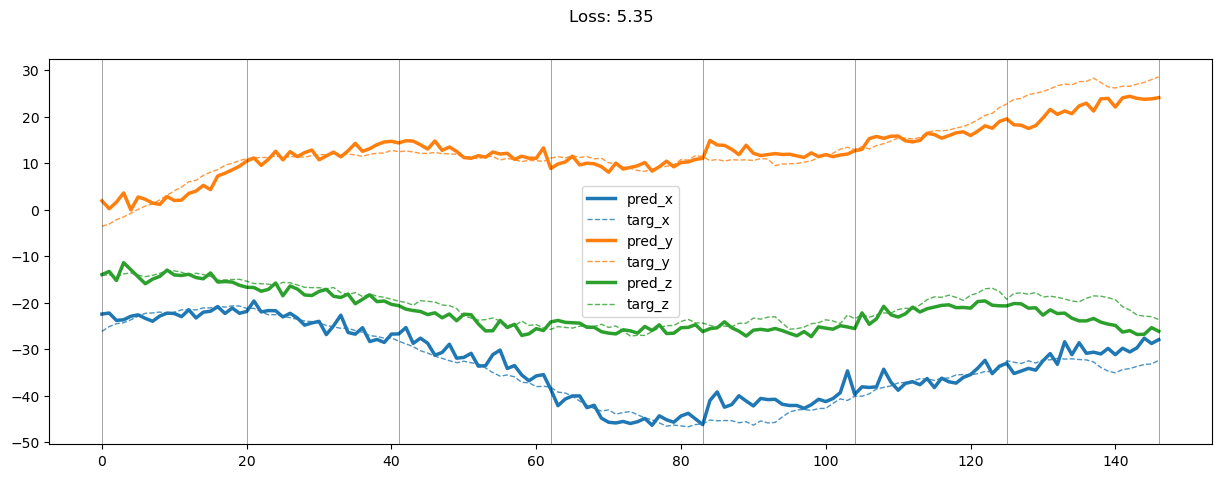

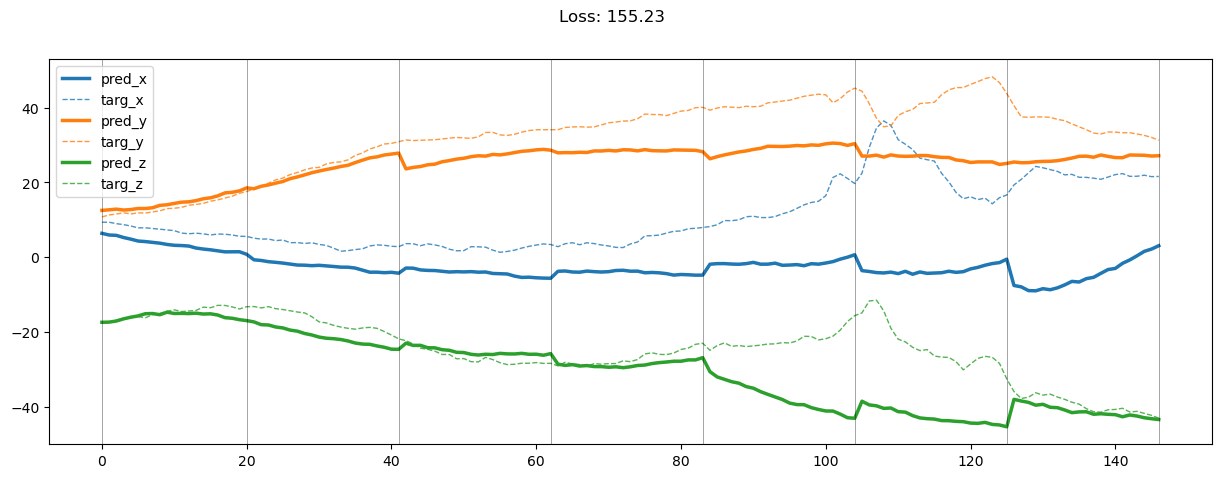

02399: train loss:  15.970, lin acc loss:  1.294, gro loss:  0.134, mag loss:  14.543
       valid loss:  75.360, lin acc loss:  0.665, gro loss:  0.076, mag loss:  74.620
02419: train loss:  13.438, lin acc loss:  1.300, gro loss:  0.139, mag loss:  11.999
       valid loss:  76.123, lin acc loss:  0.666, gro loss:  0.076, mag loss:  75.381
02439: train loss:  18.602, lin acc loss:  1.236, gro loss:  0.130, mag loss:  17.236
       valid loss:  76.039, lin acc loss:  0.666, gro loss:  0.075, mag loss:  75.298
02459: train loss:  14.544, lin acc loss:  1.239, gro loss:  0.129, mag loss:  13.176
       valid loss:  75.888, lin acc loss:  0.666, gro loss:  0.075, mag loss:  75.147
02479: train loss:  14.072, lin acc loss:  1.267, gro loss:  0.134, mag loss:  12.671
       valid loss:  75.068, lin acc loss:  0.666, gro loss:  0.075, mag loss:  74.328
02499: train loss:  12.267, lin acc loss:  1.220, gro loss:  0.116, mag loss:  10.930
       valid loss:  73.476, lin acc loss:  0.665, gro 

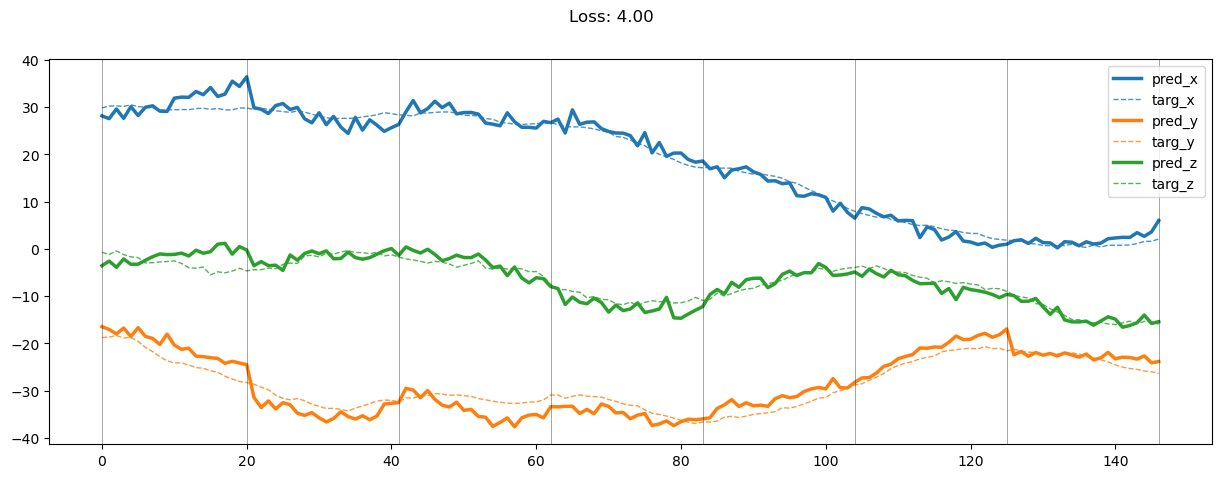

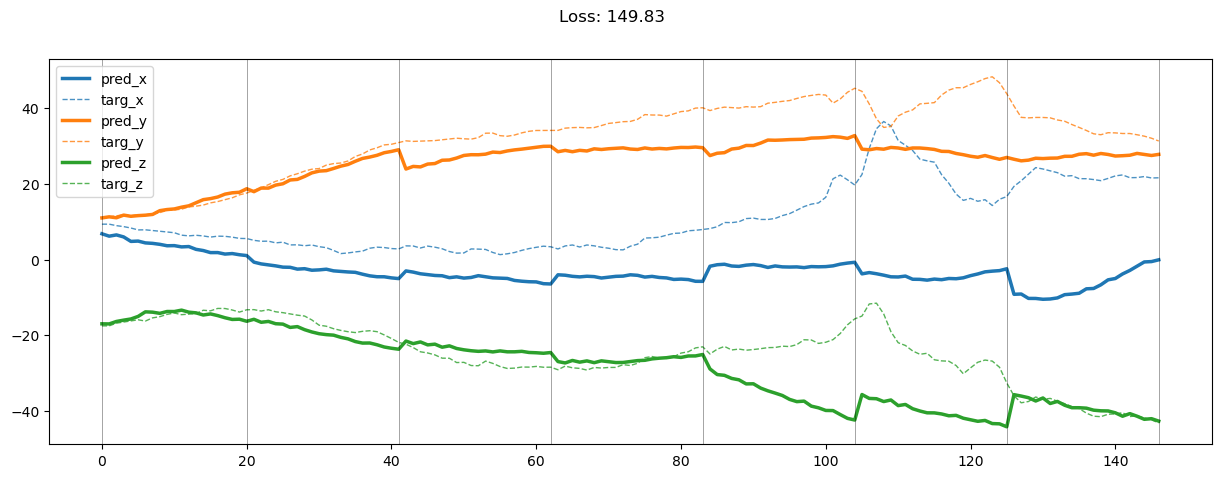

02599: train loss:  11.404, lin acc loss:  1.256, gro loss:  0.134, mag loss:  10.015
       valid loss:  73.160, lin acc loss:  0.664, gro loss:  0.075, mag loss:  72.420
02619: train loss:  12.370, lin acc loss:  1.311, gro loss:  0.133, mag loss:  10.926
       valid loss:  75.203, lin acc loss:  0.664, gro loss:  0.075, mag loss:  74.464
02639: train loss:  11.613, lin acc loss:  1.220, gro loss:  0.122, mag loss:  10.270
       valid loss:  75.542, lin acc loss:  0.665, gro loss:  0.075, mag loss:  74.802
02659: train loss:  12.822, lin acc loss:  1.273, gro loss:  0.145, mag loss:  11.404
       valid loss:  71.115, lin acc loss:  0.664, gro loss:  0.075, mag loss:  70.376
02679: train loss:  9.928, lin acc loss:  1.251, gro loss:  0.132, mag loss:  8.545
       valid loss:  72.305, lin acc loss:  0.665, gro loss:  0.075, mag loss:  71.566
02699: train loss:  11.557, lin acc loss:  1.251, gro loss:  0.141, mag loss:  10.165
       valid loss:  75.236, lin acc loss:  0.665, gro lo

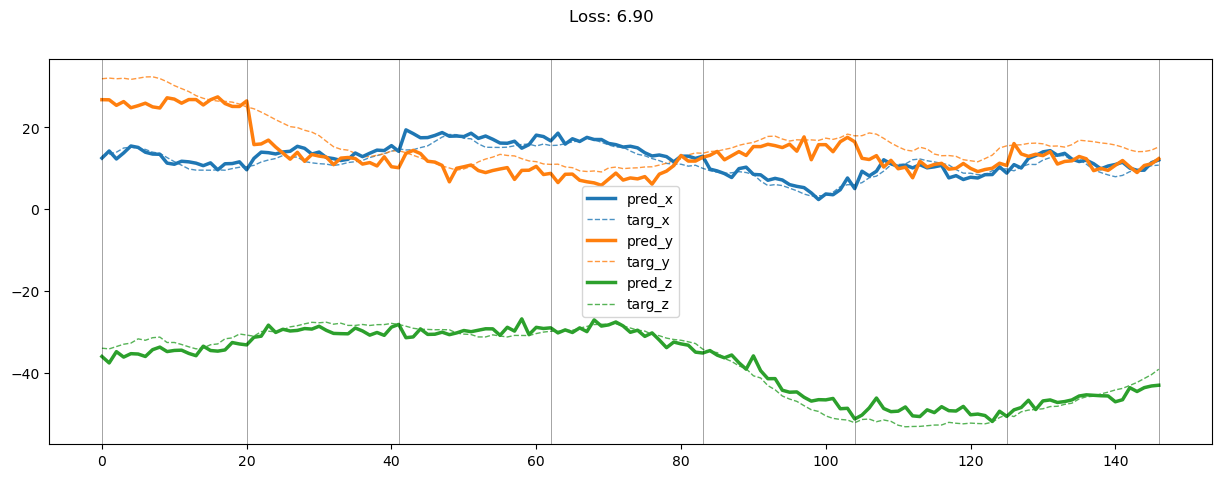

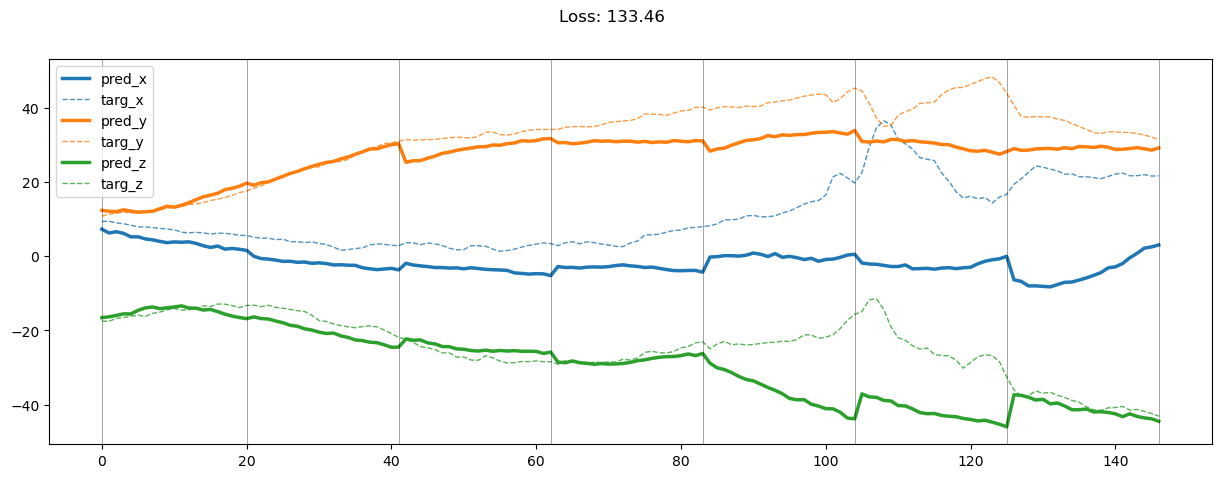

02799: train loss:  10.303, lin acc loss:  1.258, gro loss:  0.137, mag loss:  8.908
       valid loss:  72.808, lin acc loss:  0.665, gro loss:  0.074, mag loss:  72.068
02819: train loss:  11.064, lin acc loss:  1.306, gro loss:  0.135, mag loss:  9.623
       valid loss:  73.850, lin acc loss:  0.665, gro loss:  0.075, mag loss:  73.111
02839: train loss:  9.487, lin acc loss:  1.269, gro loss:  0.132, mag loss:  8.085
       valid loss:  74.073, lin acc loss:  0.664, gro loss:  0.074, mag loss:  73.334
02859: train loss:  9.914, lin acc loss:  1.237, gro loss:  0.120, mag loss:  8.557
       valid loss:  75.787, lin acc loss:  0.664, gro loss:  0.074, mag loss:  75.049
02879: train loss:  9.414, lin acc loss:  1.218, gro loss:  0.133, mag loss:  8.064
       valid loss:  74.046, lin acc loss:  0.665, gro loss:  0.075, mag loss:  73.307
02899: train loss:  9.495, lin acc loss:  1.238, gro loss:  0.129, mag loss:  8.128
       valid loss:  74.744, lin acc loss:  0.664, gro loss:  0.0

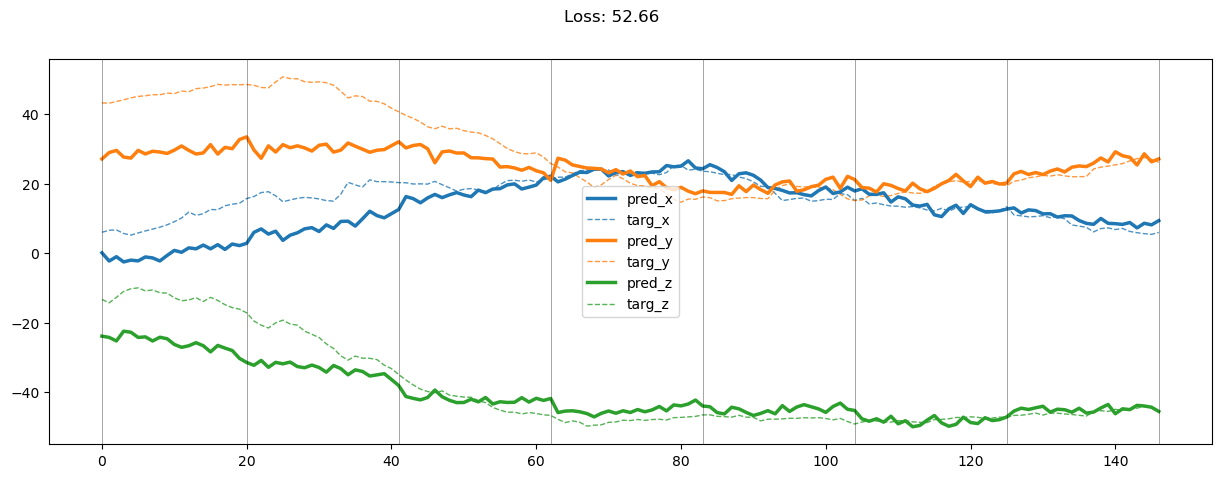

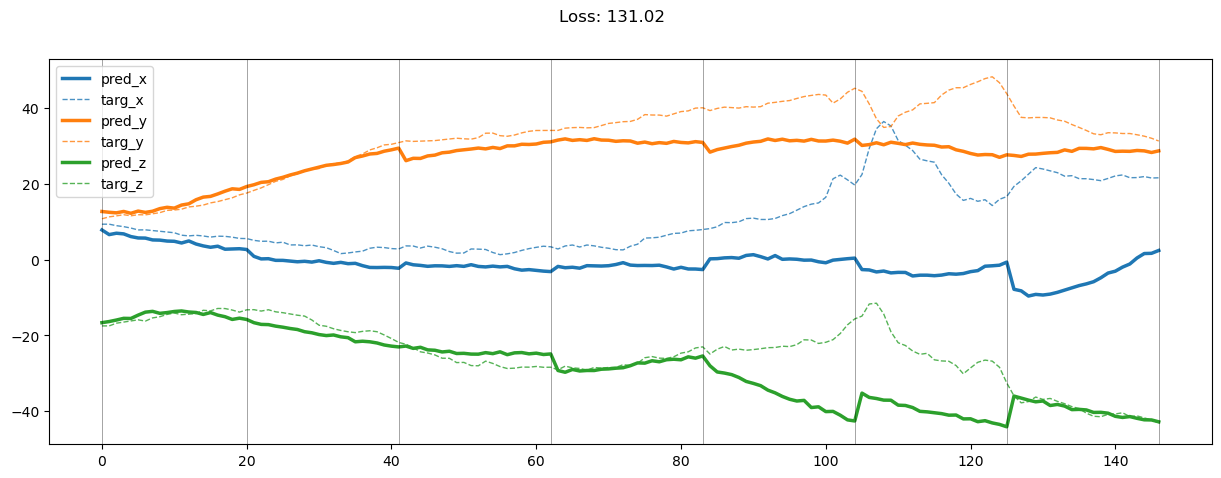

02999: train loss:  10.097, lin acc loss:  1.223, gro loss:  0.131, mag loss:  8.743
       valid loss:  70.454, lin acc loss:  0.664, gro loss:  0.074, mag loss:  69.717
03019: train loss:  8.732, lin acc loss:  1.290, gro loss:  0.123, mag loss:  7.319
       valid loss:  74.263, lin acc loss:  0.664, gro loss:  0.074, mag loss:  73.526
03039: train loss:  9.578, lin acc loss:  1.227, gro loss:  0.125, mag loss:  8.226
       valid loss:  72.388, lin acc loss:  0.665, gro loss:  0.074, mag loss:  71.649
03059: train loss:  9.165, lin acc loss:  1.257, gro loss:  0.126, mag loss:  7.781
       valid loss:  74.240, lin acc loss:  0.664, gro loss:  0.074, mag loss:  73.502
03079: train loss:  8.246, lin acc loss:  1.290, gro loss:  0.140, mag loss:  6.817
       valid loss:  72.639, lin acc loss:  0.663, gro loss:  0.073, mag loss:  71.902
03099: train loss:  8.203, lin acc loss:  1.235, gro loss:  0.131, mag loss:  6.837
       valid loss:  74.615, lin acc loss:  0.663, gro loss:  0.07

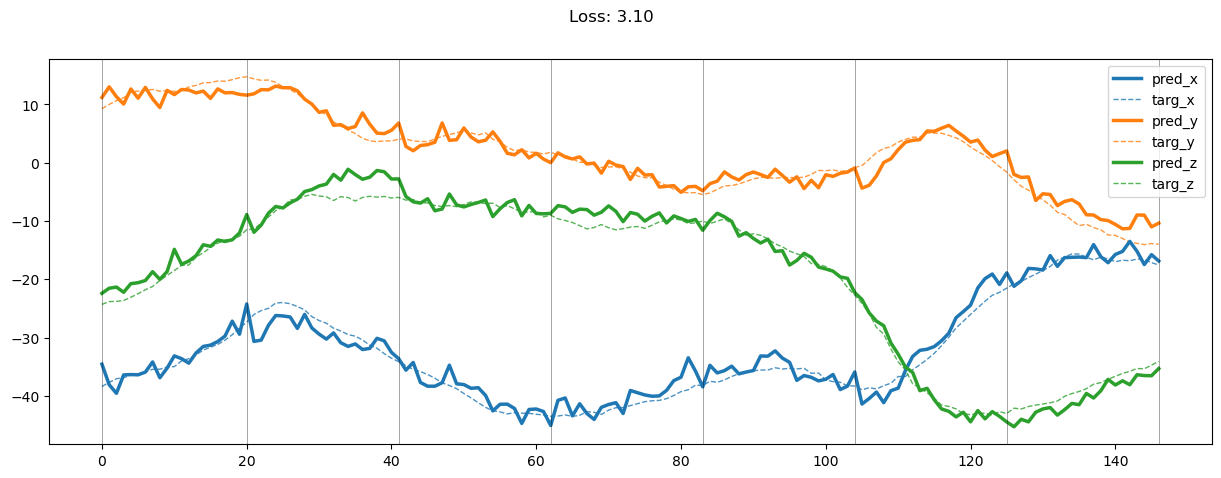

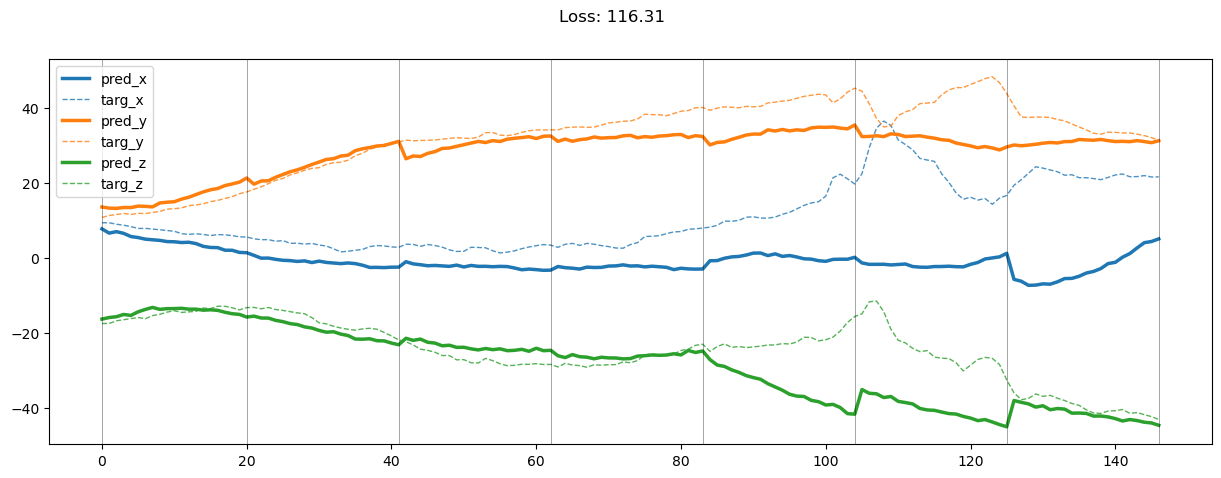

03199: train loss:  7.377, lin acc loss:  1.229, gro loss:  0.113, mag loss:  6.034
       valid loss:  75.666, lin acc loss:  0.664, gro loss:  0.074, mag loss:  74.928
03219: train loss:  8.504, lin acc loss:  1.276, gro loss:  0.132, mag loss:  7.096
       valid loss:  75.938, lin acc loss:  0.664, gro loss:  0.073, mag loss:  75.201
03239: train loss:  8.078, lin acc loss:  1.212, gro loss:  0.135, mag loss:  6.731
       valid loss:  75.658, lin acc loss:  0.664, gro loss:  0.073, mag loss:  74.921
03259: train loss:  7.055, lin acc loss:  1.170, gro loss:  0.124, mag loss:  5.760
       valid loss:  73.774, lin acc loss:  0.664, gro loss:  0.073, mag loss:  73.037
03279: train loss:  6.718, lin acc loss:  1.246, gro loss:  0.124, mag loss:  5.348
       valid loss:  76.770, lin acc loss:  0.664, gro loss:  0.073, mag loss:  76.033
03299: train loss:  7.085, lin acc loss:  1.219, gro loss:  0.119, mag loss:  5.746
       valid loss:  72.029, lin acc loss:  0.663, gro loss:  0.073

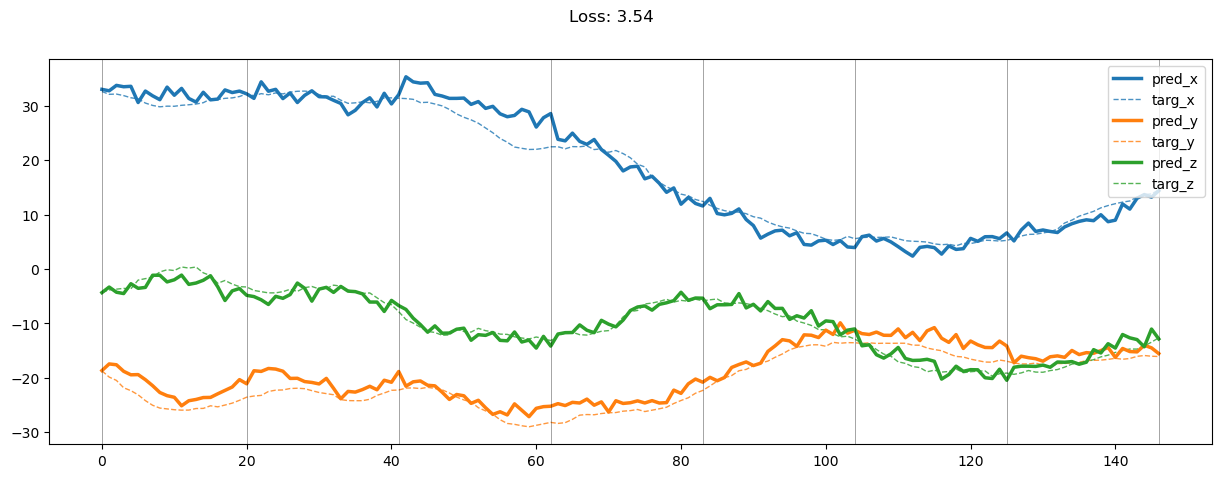

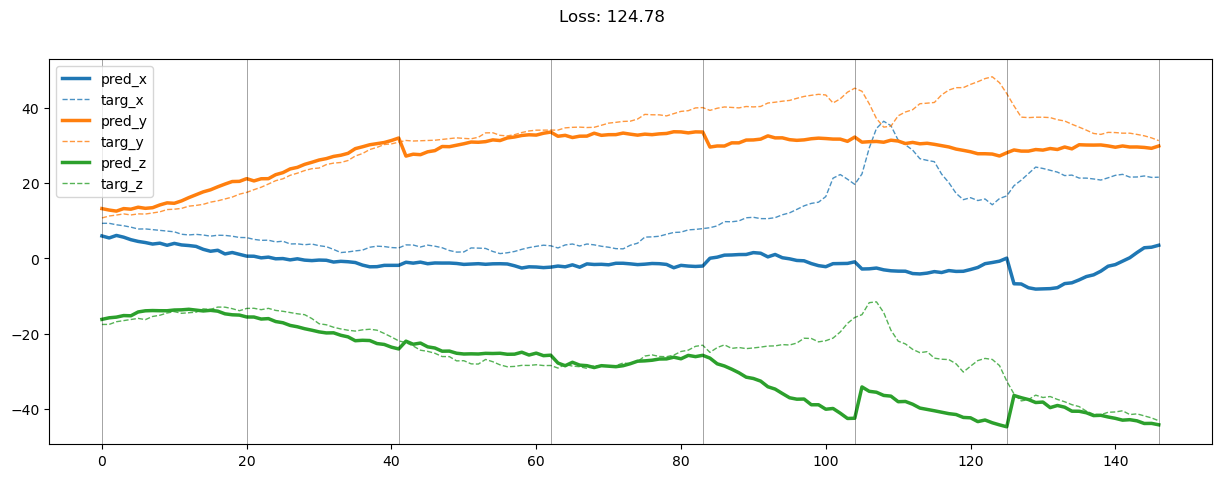

03399: train loss:  6.899, lin acc loss:  1.214, gro loss:  0.135, mag loss:  5.550
       valid loss:  72.461, lin acc loss:  0.664, gro loss:  0.073, mag loss:  71.724
03419: train loss:  6.432, lin acc loss:  1.261, gro loss:  0.134, mag loss:  5.037
       valid loss:  74.274, lin acc loss:  0.664, gro loss:  0.073, mag loss:  73.538
03439: train loss:  6.798, lin acc loss:  1.252, gro loss:  0.129, mag loss:  5.417
       valid loss:  71.782, lin acc loss:  0.664, gro loss:  0.073, mag loss:  71.046
03459: train loss:  6.547, lin acc loss:  1.228, gro loss:  0.131, mag loss:  5.187
       valid loss:  73.031, lin acc loss:  0.664, gro loss:  0.073, mag loss:  72.294
03479: train loss:  6.301, lin acc loss:  1.217, gro loss:  0.131, mag loss:  4.954
       valid loss:  72.939, lin acc loss:  0.664, gro loss:  0.073, mag loss:  72.203
03499: train loss:  6.704, lin acc loss:  1.235, gro loss:  0.124, mag loss:  5.344
       valid loss:  69.793, lin acc loss:  0.664, gro loss:  0.072

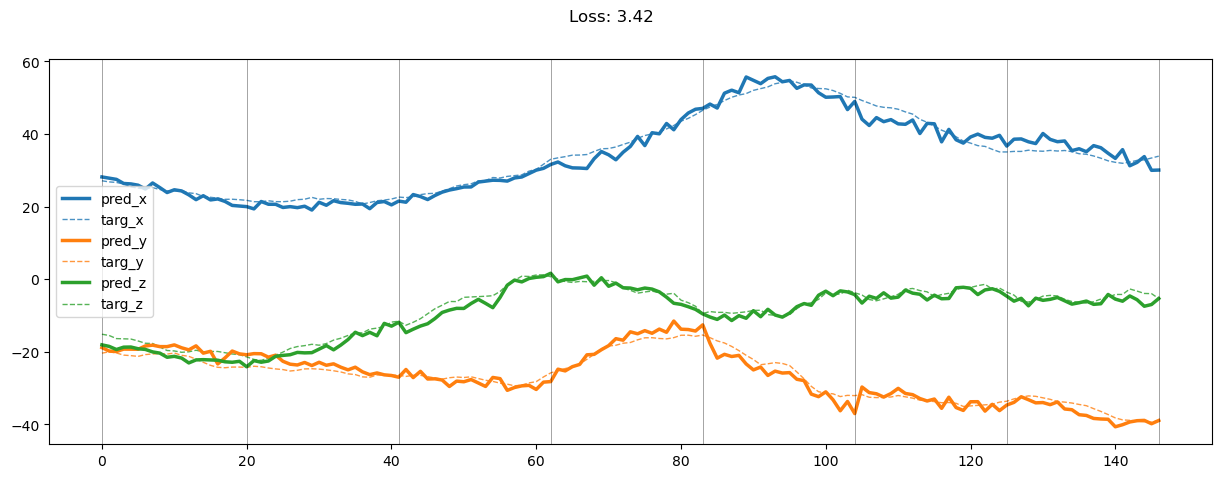

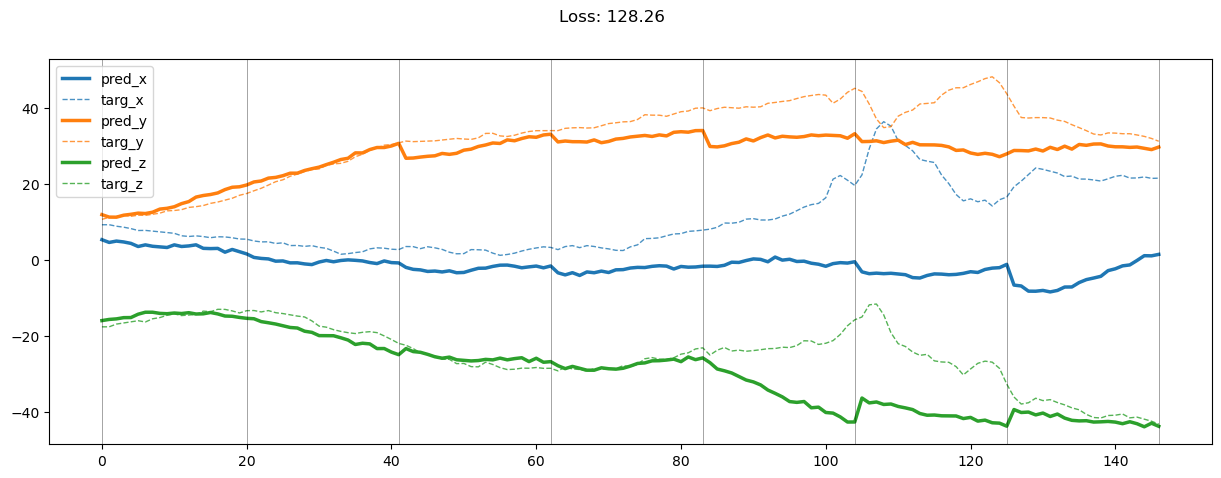

03599: train loss:  6.057, lin acc loss:  1.206, gro loss:  0.124, mag loss:  4.727
       valid loss:  72.076, lin acc loss:  0.663, gro loss:  0.072, mag loss:  71.340
03619: train loss:  5.886, lin acc loss:  1.244, gro loss:  0.126, mag loss:  4.516
       valid loss:  72.033, lin acc loss:  0.664, gro loss:  0.072, mag loss:  71.297
03639: train loss:  6.463, lin acc loss:  1.222, gro loss:  0.131, mag loss:  5.110
       valid loss:  71.797, lin acc loss:  0.664, gro loss:  0.072, mag loss:  71.061
03659: train loss:  6.335, lin acc loss:  1.194, gro loss:  0.123, mag loss:  5.019
       valid loss:  72.842, lin acc loss:  0.665, gro loss:  0.072, mag loss:  72.105
03679: train loss:  5.627, lin acc loss:  1.223, gro loss:  0.126, mag loss:  4.277
       valid loss:  70.851, lin acc loss:  0.665, gro loss:  0.072, mag loss:  70.114
03699: train loss:  5.793, lin acc loss:  1.149, gro loss:  0.120, mag loss:  4.524
       valid loss:  71.586, lin acc loss:  0.664, gro loss:  0.072

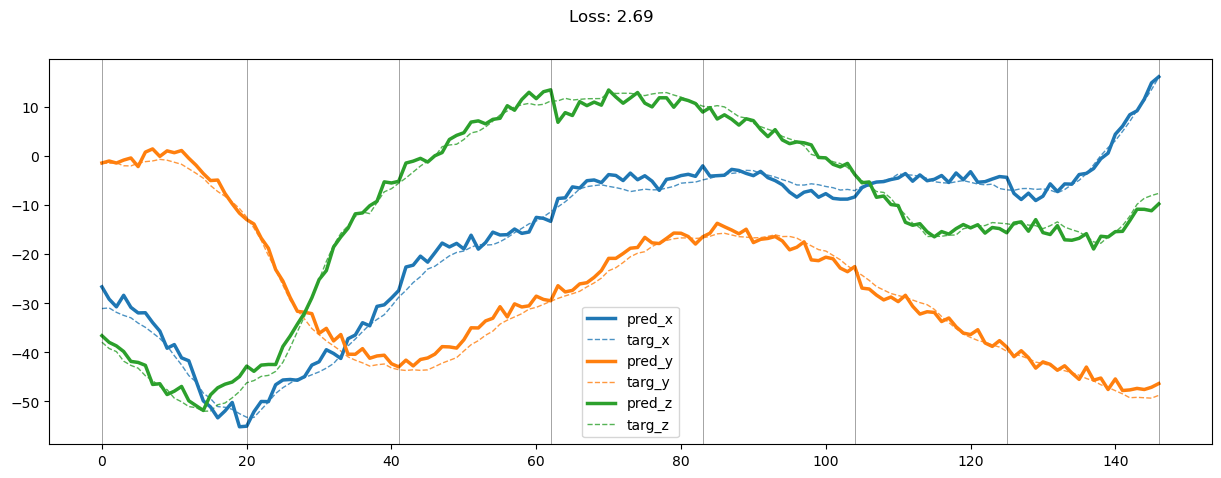

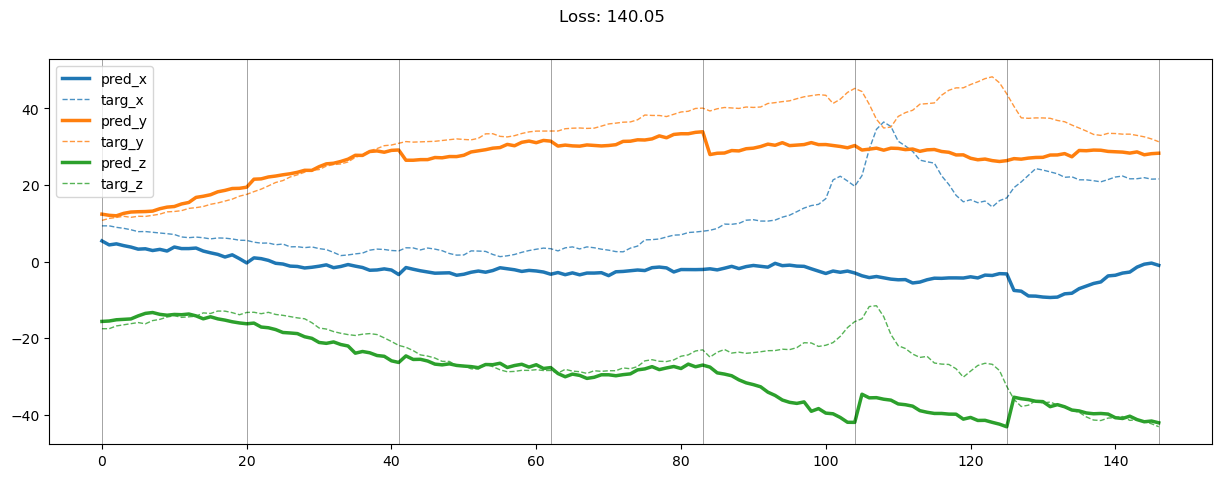

03799: train loss:  5.233, lin acc loss:  1.191, gro loss:  0.111, mag loss:  3.931
       valid loss:  71.533, lin acc loss:  0.665, gro loss:  0.072, mag loss:  70.796
03819: train loss:  5.354, lin acc loss:  1.216, gro loss:  0.133, mag loss:  4.005
       valid loss:  70.157, lin acc loss:  0.666, gro loss:  0.072, mag loss:  69.419
03839: train loss:  5.346, lin acc loss:  1.179, gro loss:  0.121, mag loss:  4.046
       valid loss:  71.126, lin acc loss:  0.666, gro loss:  0.072, mag loss:  70.388
03859: train loss:  5.153, lin acc loss:  1.239, gro loss:  0.131, mag loss:  3.783
       valid loss:  70.434, lin acc loss:  0.666, gro loss:  0.072, mag loss:  69.695
03879: train loss:  4.974, lin acc loss:  1.182, gro loss:  0.135, mag loss:  3.657
       valid loss:  70.556, lin acc loss:  0.666, gro loss:  0.072, mag loss:  69.818
03899: train loss:  5.287, lin acc loss:  1.237, gro loss:  0.121, mag loss:  3.930
       valid loss:  69.664, lin acc loss:  0.666, gro loss:  0.072

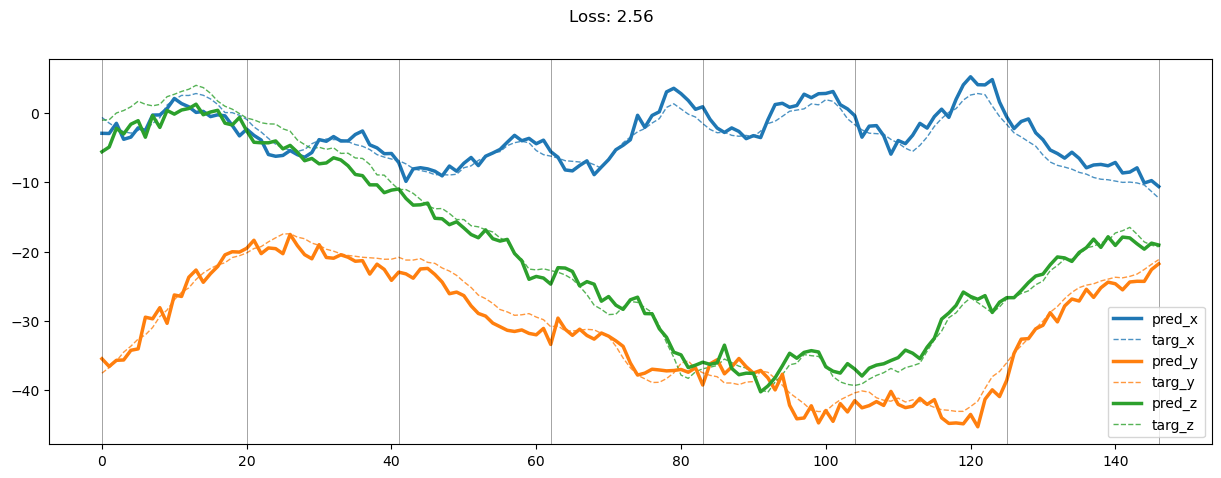

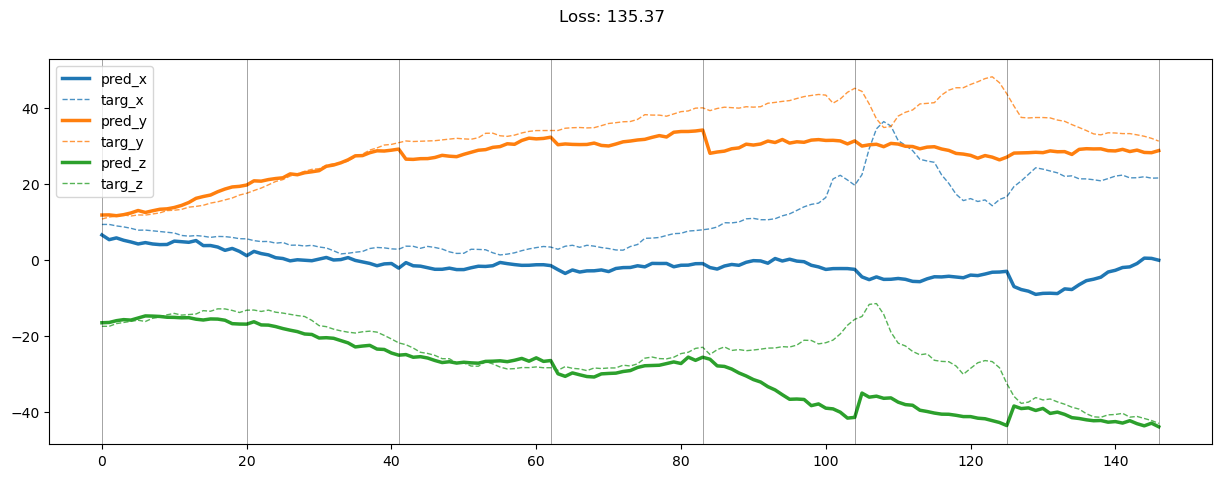

03999: train loss:  5.349, lin acc loss:  1.203, gro loss:  0.129, mag loss:  4.017
       valid loss:  71.797, lin acc loss:  0.667, gro loss:  0.072, mag loss:  71.058
04019: train loss:  4.753, lin acc loss:  1.180, gro loss:  0.123, mag loss:  3.450
       valid loss:  70.502, lin acc loss:  0.668, gro loss:  0.072, mag loss:  69.763
04039: train loss:  4.959, lin acc loss:  1.146, gro loss:  0.122, mag loss:  3.691
       valid loss:  70.312, lin acc loss:  0.668, gro loss:  0.072, mag loss:  69.572
04059: train loss:  5.104, lin acc loss:  1.177, gro loss:  0.130, mag loss:  3.797
       valid loss:  70.797, lin acc loss:  0.669, gro loss:  0.072, mag loss:  70.057
04079: train loss:  4.771, lin acc loss:  1.148, gro loss:  0.117, mag loss:  3.506
       valid loss:  69.280, lin acc loss:  0.669, gro loss:  0.072, mag loss:  68.539
04099: train loss:  4.706, lin acc loss:  1.140, gro loss:  0.126, mag loss:  3.440
       valid loss:  71.472, lin acc loss:  0.671, gro loss:  0.072

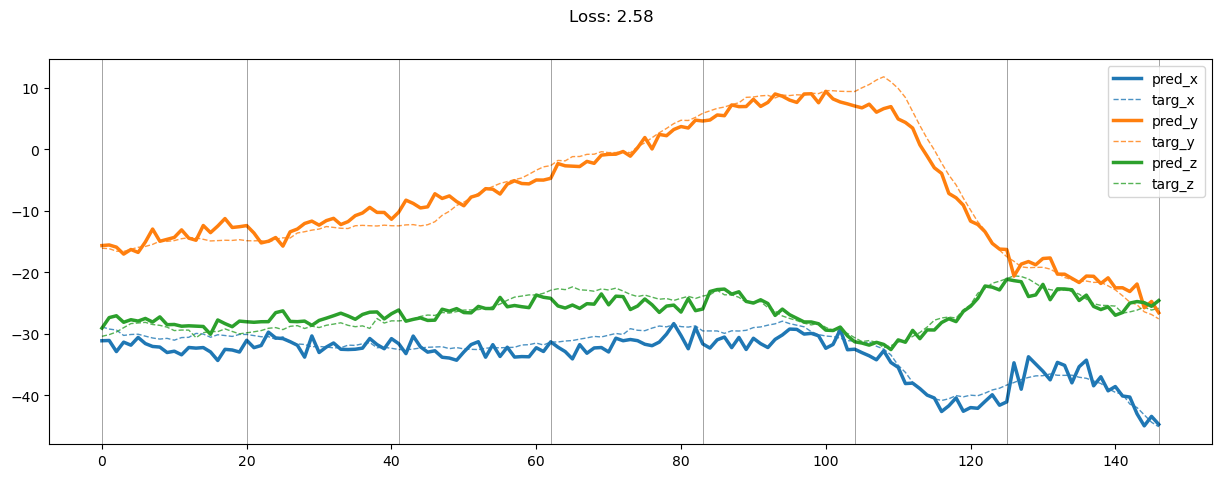

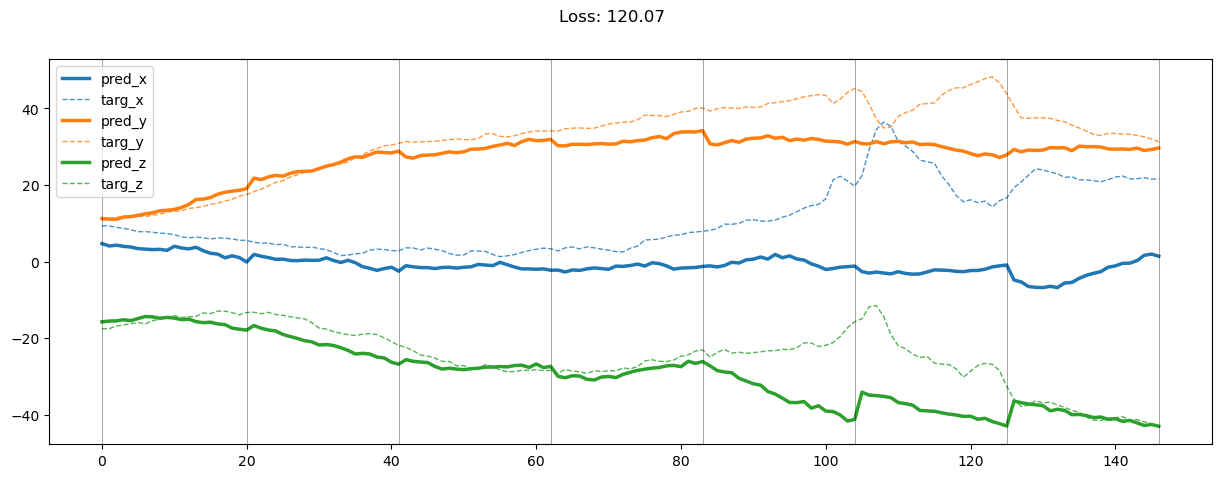

04199: train loss:  4.822, lin acc loss:  1.150, gro loss:  0.116, mag loss:  3.556
       valid loss:  69.124, lin acc loss:  0.673, gro loss:  0.071, mag loss:  68.380
04219: train loss:  4.469, lin acc loss:  1.151, gro loss:  0.116, mag loss:  3.202
       valid loss:  70.659, lin acc loss:  0.674, gro loss:  0.072, mag loss:  69.914
04239: train loss:  4.546, lin acc loss:  1.095, gro loss:  0.121, mag loss:  3.330
       valid loss:  71.933, lin acc loss:  0.675, gro loss:  0.071, mag loss:  71.186
04259: train loss:  4.599, lin acc loss:  1.102, gro loss:  0.127, mag loss:  3.369
       valid loss:  68.857, lin acc loss:  0.675, gro loss:  0.071, mag loss:  68.111
04279: train loss:  4.441, lin acc loss:  1.133, gro loss:  0.123, mag loss:  3.185
       valid loss:  70.436, lin acc loss:  0.676, gro loss:  0.071, mag loss:  69.689
04299: train loss:  4.667, lin acc loss:  1.116, gro loss:  0.121, mag loss:  3.429
       valid loss:  75.174, lin acc loss:  0.679, gro loss:  0.072

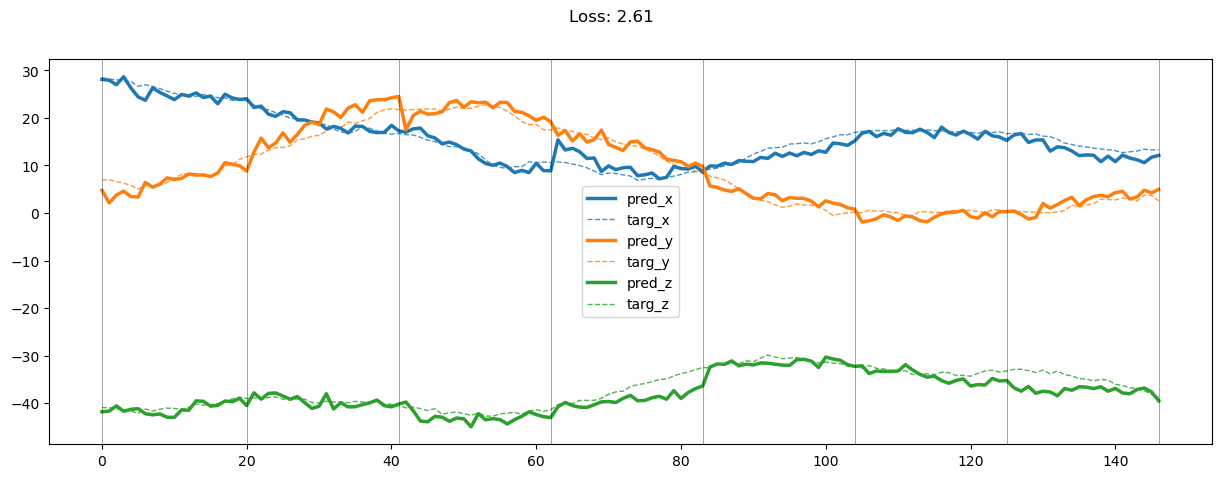

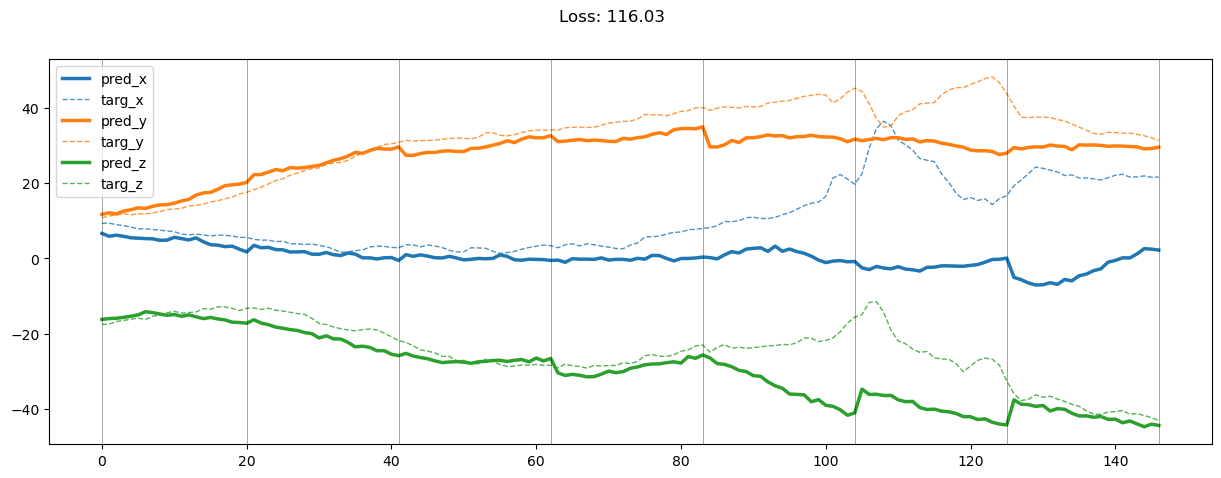

04399: train loss:  4.313, lin acc loss:  1.050, gro loss:  0.117, mag loss:  3.146
       valid loss:  72.607, lin acc loss:  0.683, gro loss:  0.071, mag loss:  71.852
04419: train loss:  4.035, lin acc loss:  1.063, gro loss:  0.121, mag loss:  2.851
       valid loss:  72.034, lin acc loss:  0.684, gro loss:  0.071, mag loss:  71.278
04439: train loss:  4.006, lin acc loss:  1.056, gro loss:  0.116, mag loss:  2.833
       valid loss:  70.167, lin acc loss:  0.686, gro loss:  0.071, mag loss:  69.410
04459: train loss:  4.554, lin acc loss:  1.042, gro loss:  0.131, mag loss:  3.381
       valid loss:  72.993, lin acc loss:  0.689, gro loss:  0.072, mag loss:  72.233
04479: train loss:  4.434, lin acc loss:  1.025, gro loss:  0.123, mag loss:  3.286
       valid loss:  70.956, lin acc loss:  0.690, gro loss:  0.072, mag loss:  70.195
04499: train loss:  4.351, lin acc loss:  1.056, gro loss:  0.121, mag loss:  3.173
       valid loss:  70.945, lin acc loss:  0.694, gro loss:  0.072

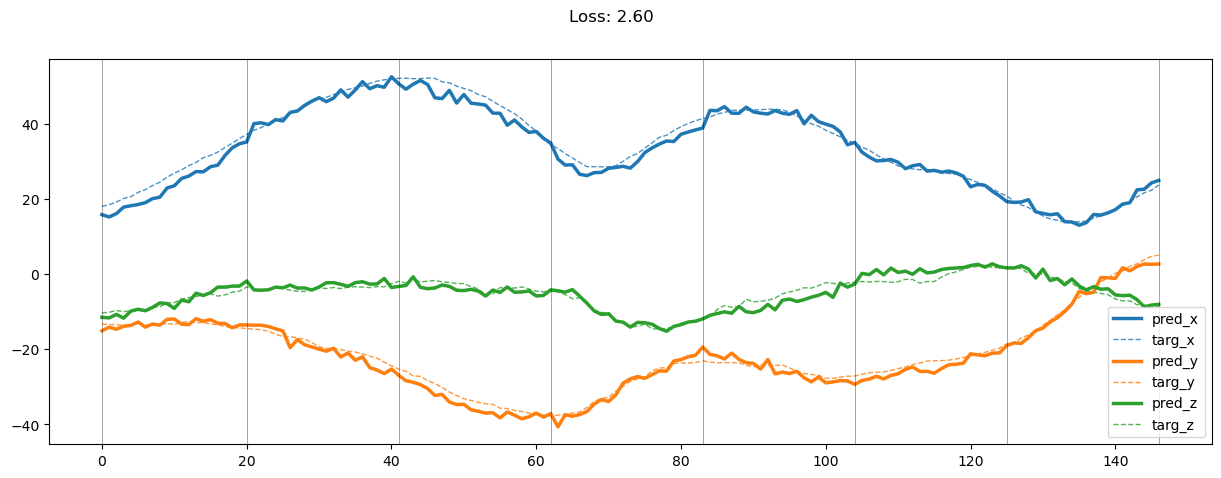

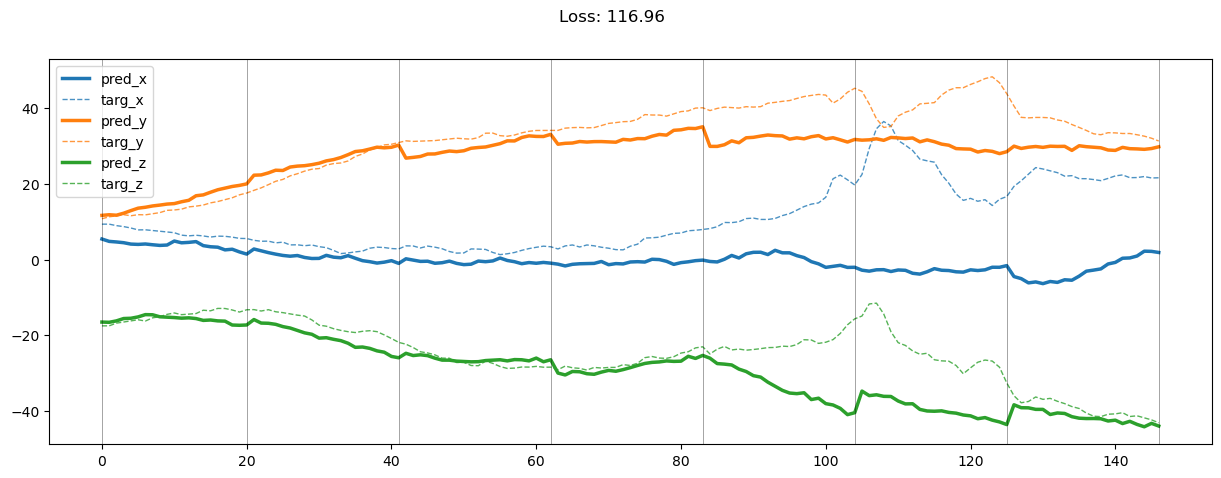

04599: train loss:  3.863, lin acc loss:  0.990, gro loss:  0.121, mag loss:  2.752
       valid loss:  69.175, lin acc loss:  0.700, gro loss:  0.071, mag loss:  68.404
04619: train loss:  4.068, lin acc loss:  1.022, gro loss:  0.124, mag loss:  2.922
       valid loss:  71.142, lin acc loss:  0.702, gro loss:  0.071, mag loss:  70.368
04639: train loss:  4.054, lin acc loss:  0.978, gro loss:  0.120, mag loss:  2.955
       valid loss:  72.262, lin acc loss:  0.704, gro loss:  0.071, mag loss:  71.486
04659: train loss:  4.203, lin acc loss:  0.994, gro loss:  0.119, mag loss:  3.091
       valid loss:  71.531, lin acc loss:  0.702, gro loss:  0.072, mag loss:  70.758
04679: train loss:  3.947, lin acc loss:  0.943, gro loss:  0.118, mag loss:  2.885
       valid loss:  70.437, lin acc loss:  0.705, gro loss:  0.071, mag loss:  69.660
04699: train loss:  3.756, lin acc loss:  0.950, gro loss:  0.125, mag loss:  2.681
       valid loss:  72.483, lin acc loss:  0.710, gro loss:  0.071

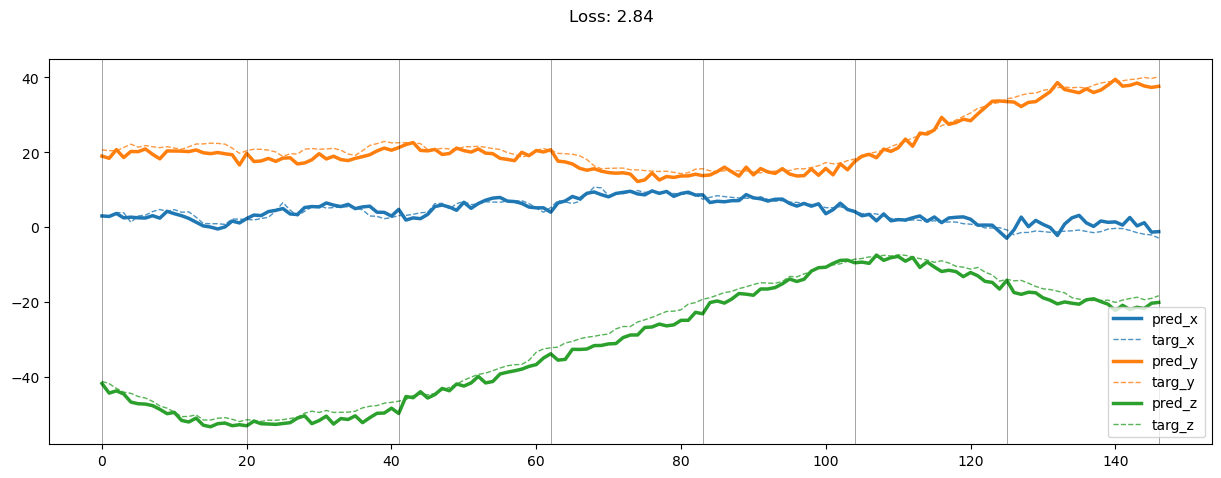

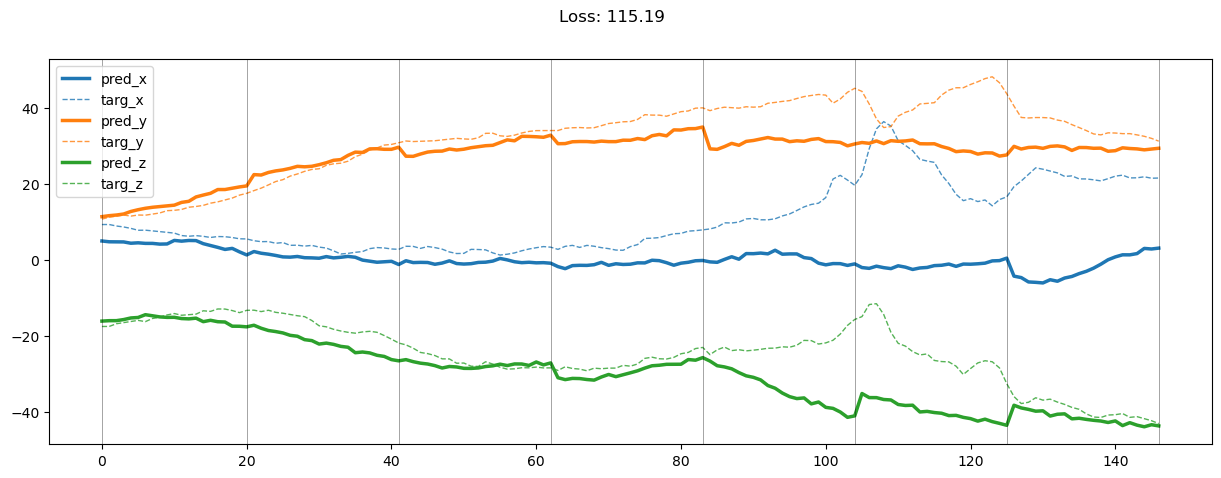

04799: train loss:  3.848, lin acc loss:  0.930, gro loss:  0.120, mag loss:  2.798
       valid loss:  71.250, lin acc loss:  0.717, gro loss:  0.071, mag loss:  70.462
04819: train loss:  3.717, lin acc loss:  0.907, gro loss:  0.117, mag loss:  2.693
       valid loss:  71.919, lin acc loss:  0.721, gro loss:  0.071, mag loss:  71.126
04839: train loss:  3.640, lin acc loss:  0.925, gro loss:  0.122, mag loss:  2.592
       valid loss:  70.874, lin acc loss:  0.719, gro loss:  0.071, mag loss:  70.084
04859: train loss:  3.566, lin acc loss:  0.872, gro loss:  0.116, mag loss:  2.577
       valid loss:  71.234, lin acc loss:  0.723, gro loss:  0.072, mag loss:  70.440
04879: train loss:  3.466, lin acc loss:  0.896, gro loss:  0.109, mag loss:  2.461
       valid loss:  70.089, lin acc loss:  0.725, gro loss:  0.071, mag loss:  69.292
04899: train loss:  3.827, lin acc loss:  0.898, gro loss:  0.124, mag loss:  2.804
       valid loss:  70.471, lin acc loss:  0.724, gro loss:  0.071

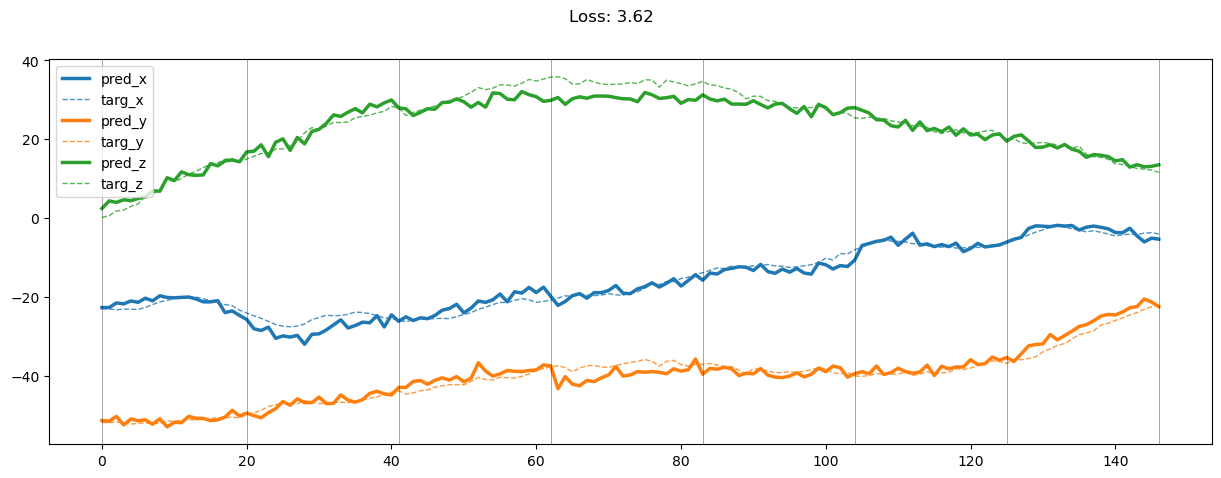

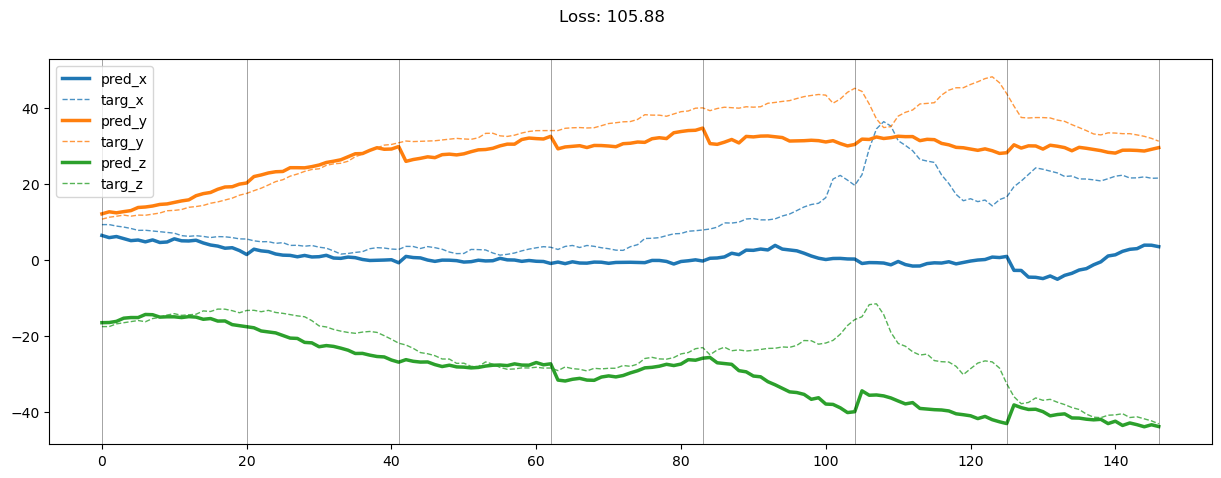

04999: train loss:  3.688, lin acc loss:  0.857, gro loss:  0.125, mag loss:  2.706
       valid loss:  71.576, lin acc loss:  0.747, gro loss:  0.072, mag loss:  70.757
05019: train loss:  3.405, lin acc loss:  0.824, gro loss:  0.114, mag loss:  2.467
       valid loss:  71.928, lin acc loss:  0.741, gro loss:  0.072, mag loss:  71.115
05039: train loss:  3.496, lin acc loss:  0.868, gro loss:  0.118, mag loss:  2.510
       valid loss:  68.955, lin acc loss:  0.745, gro loss:  0.071, mag loss:  68.138
05059: train loss:  3.310, lin acc loss:  0.833, gro loss:  0.112, mag loss:  2.365
       valid loss:  72.224, lin acc loss:  0.747, gro loss:  0.071, mag loss:  71.406
05079: train loss:  3.619, lin acc loss:  0.859, gro loss:  0.122, mag loss:  2.639
       valid loss:  72.392, lin acc loss:  0.750, gro loss:  0.071, mag loss:  71.571
05099: train loss:  3.297, lin acc loss:  0.845, gro loss:  0.120, mag loss:  2.332
       valid loss:  72.243, lin acc loss:  0.753, gro loss:  0.072

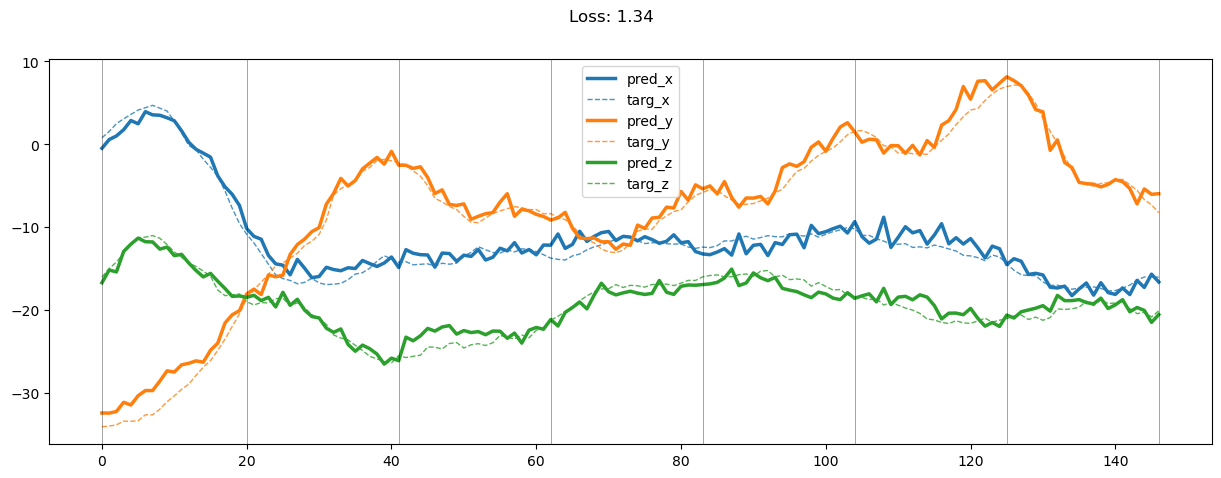

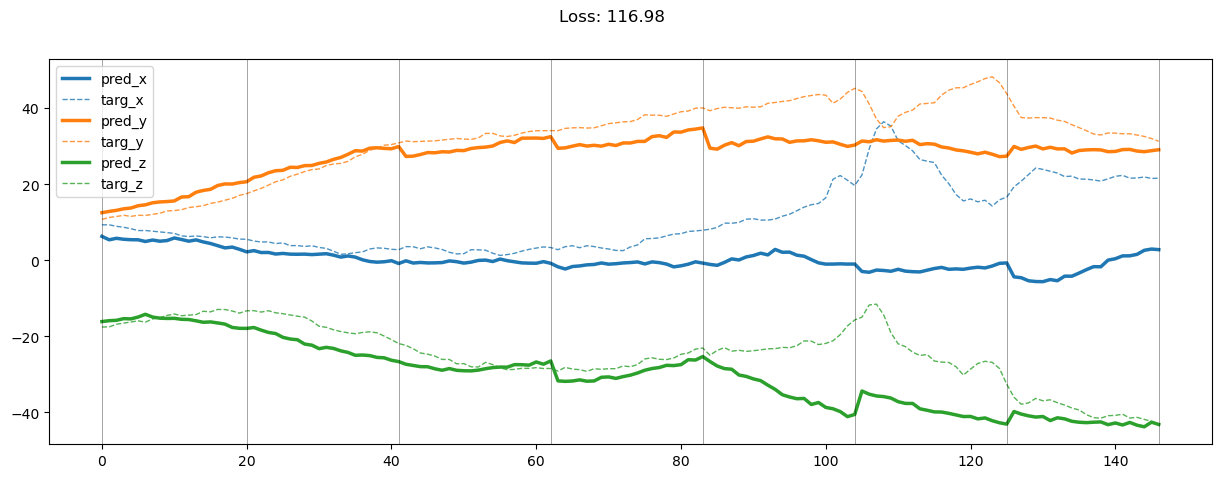

05199: train loss:  3.439, lin acc loss:  0.778, gro loss:  0.112, mag loss:  2.548
       valid loss:  70.052, lin acc loss:  0.761, gro loss:  0.071, mag loss:  69.219
05219: train loss:  3.322, lin acc loss:  0.788, gro loss:  0.113, mag loss:  2.421
       valid loss:  70.267, lin acc loss:  0.760, gro loss:  0.071, mag loss:  69.435
05239: train loss:  3.359, lin acc loss:  0.777, gro loss:  0.118, mag loss:  2.464
       valid loss:  72.362, lin acc loss:  0.761, gro loss:  0.071, mag loss:  71.530
05259: train loss:  3.251, lin acc loss:  0.767, gro loss:  0.117, mag loss:  2.367
       valid loss:  70.207, lin acc loss:  0.774, gro loss:  0.072, mag loss:  69.362
05279: train loss:  3.033, lin acc loss:  0.747, gro loss:  0.126, mag loss:  2.160
       valid loss:  70.583, lin acc loss:  0.769, gro loss:  0.071, mag loss:  69.743
05299: train loss:  3.004, lin acc loss:  0.776, gro loss:  0.118, mag loss:  2.109
       valid loss:  69.382, lin acc loss:  0.766, gro loss:  0.071

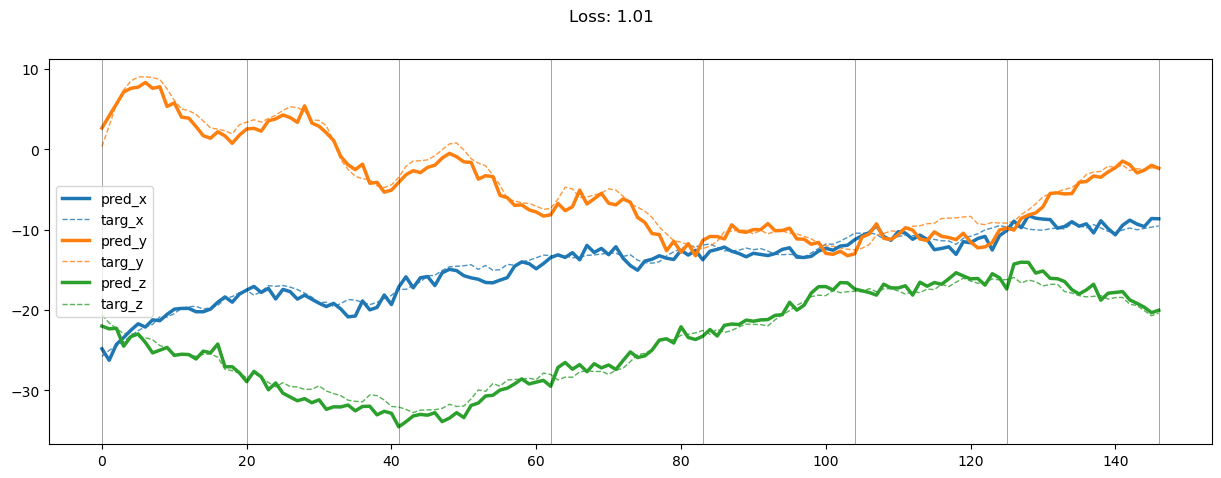

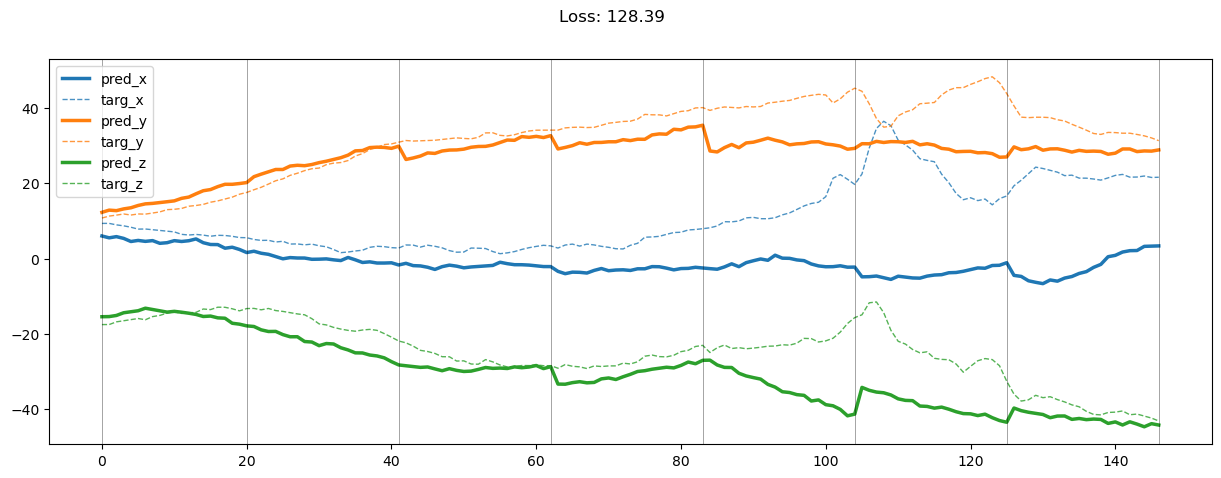

05399: train loss:  3.068, lin acc loss:  0.689, gro loss:  0.113, mag loss:  2.266
       valid loss:  69.212, lin acc loss:  0.779, gro loss:  0.071, mag loss:  68.362
05419: train loss:  2.982, lin acc loss:  0.723, gro loss:  0.109, mag loss:  2.150
       valid loss:  69.881, lin acc loss:  0.779, gro loss:  0.071, mag loss:  69.031
05439: train loss:  3.085, lin acc loss:  0.727, gro loss:  0.121, mag loss:  2.238
       valid loss:  70.151, lin acc loss:  0.778, gro loss:  0.071, mag loss:  69.302
05459: train loss:  2.898, lin acc loss:  0.741, gro loss:  0.112, mag loss:  2.045
       valid loss:  69.550, lin acc loss:  0.782, gro loss:  0.071, mag loss:  68.697
05479: train loss:  2.989, lin acc loss:  0.732, gro loss:  0.115, mag loss:  2.142
       valid loss:  69.891, lin acc loss:  0.784, gro loss:  0.071, mag loss:  69.035
05499: train loss:  2.910, lin acc loss:  0.664, gro loss:  0.106, mag loss:  2.140
       valid loss:  68.956, lin acc loss:  0.784, gro loss:  0.071

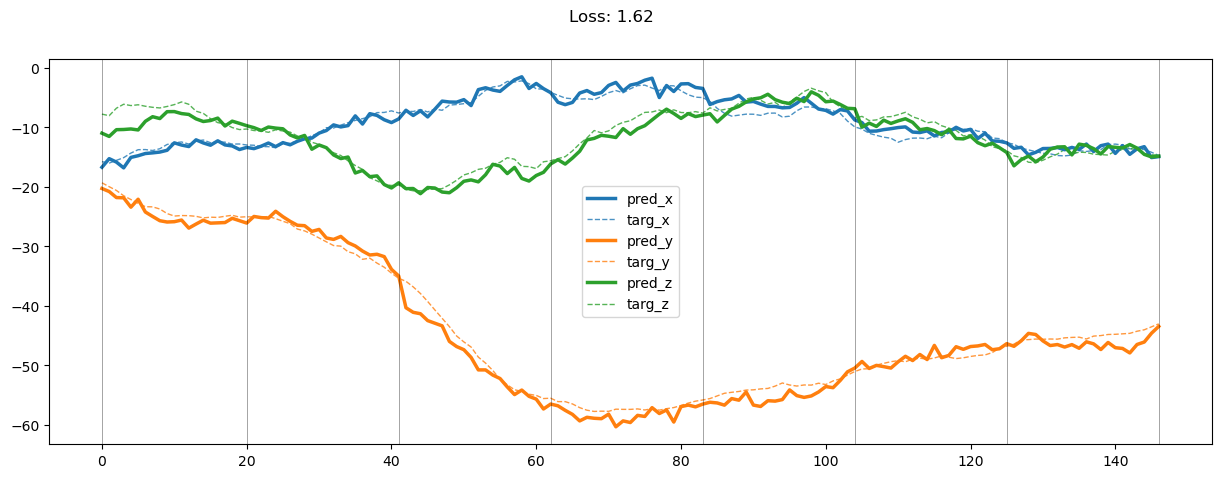

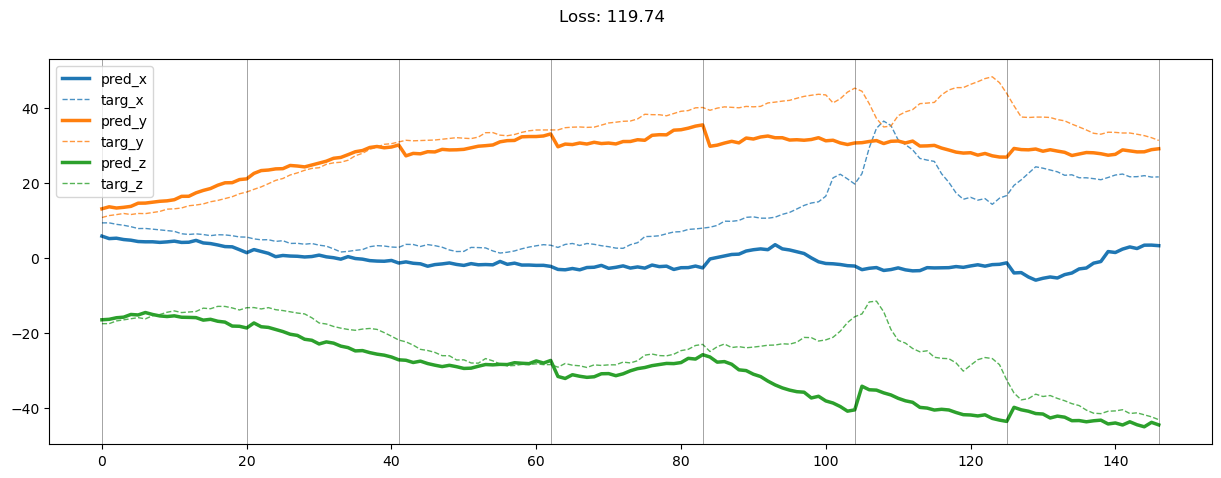

05599: train loss:  2.873, lin acc loss:  0.686, gro loss:  0.118, mag loss:  2.070
       valid loss:  68.735, lin acc loss:  0.786, gro loss:  0.071, mag loss:  67.878
05619: train loss:  2.770, lin acc loss:  0.664, gro loss:  0.114, mag loss:  1.991
       valid loss:  69.643, lin acc loss:  0.800, gro loss:  0.072, mag loss:  68.771
05639: train loss:  2.766, lin acc loss:  0.668, gro loss:  0.116, mag loss:  1.981
       valid loss:  69.007, lin acc loss:  0.801, gro loss:  0.072, mag loss:  68.134
05659: train loss:  2.691, lin acc loss:  0.631, gro loss:  0.104, mag loss:  1.957
       valid loss:  70.579, lin acc loss:  0.794, gro loss:  0.072, mag loss:  69.714
05679: train loss:  2.782, lin acc loss:  0.614, gro loss:  0.106, mag loss:  2.062
       valid loss:  70.844, lin acc loss:  0.793, gro loss:  0.072, mag loss:  69.980
05699: train loss:  2.603, lin acc loss:  0.620, gro loss:  0.110, mag loss:  1.872
       valid loss:  70.355, lin acc loss:  0.792, gro loss:  0.072

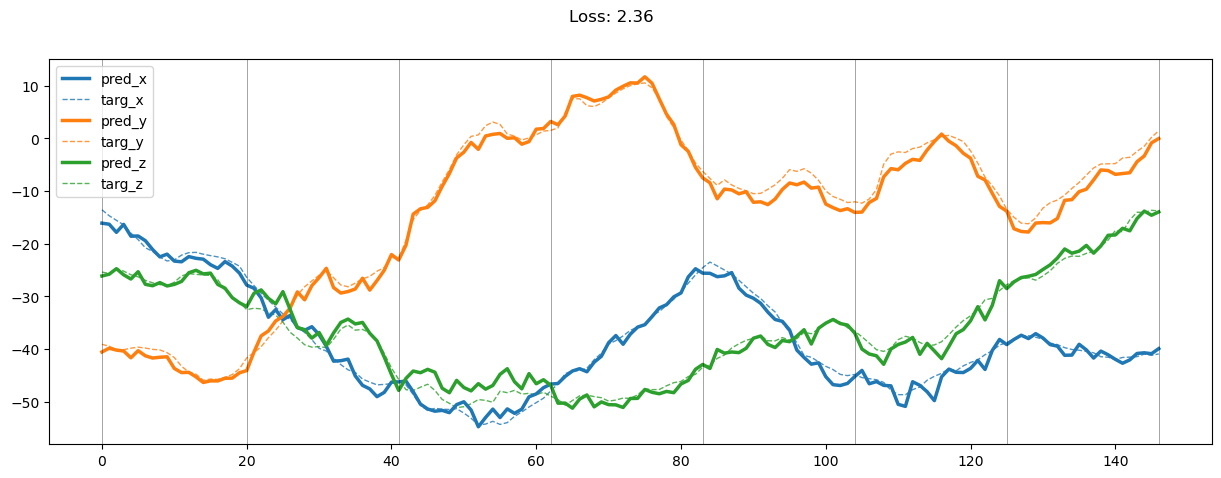

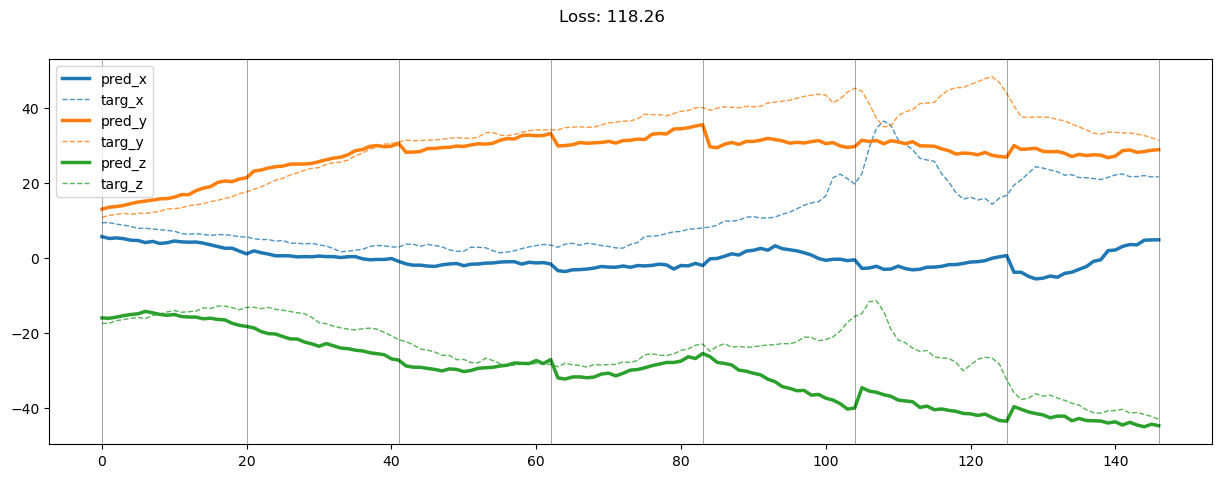

05799: train loss:  2.782, lin acc loss:  0.626, gro loss:  0.116, mag loss:  2.040
       valid loss:  70.550, lin acc loss:  0.812, gro loss:  0.072, mag loss:  69.666
05819: train loss:  2.700, lin acc loss:  0.617, gro loss:  0.110, mag loss:  1.973
       valid loss:  71.190, lin acc loss:  0.806, gro loss:  0.072, mag loss:  70.312
05839: train loss:  2.734, lin acc loss:  0.613, gro loss:  0.116, mag loss:  2.005
       valid loss:  70.399, lin acc loss:  0.809, gro loss:  0.072, mag loss:  69.518
05859: train loss:  2.504, lin acc loss:  0.595, gro loss:  0.109, mag loss:  1.799
       valid loss:  71.625, lin acc loss:  0.811, gro loss:  0.072, mag loss:  70.743
05879: train loss:  2.466, lin acc loss:  0.603, gro loss:  0.106, mag loss:  1.758
       valid loss:  71.264, lin acc loss:  0.806, gro loss:  0.072, mag loss:  70.386
05899: train loss:  2.562, lin acc loss:  0.573, gro loss:  0.106, mag loss:  1.882
       valid loss:  69.161, lin acc loss:  0.807, gro loss:  0.072

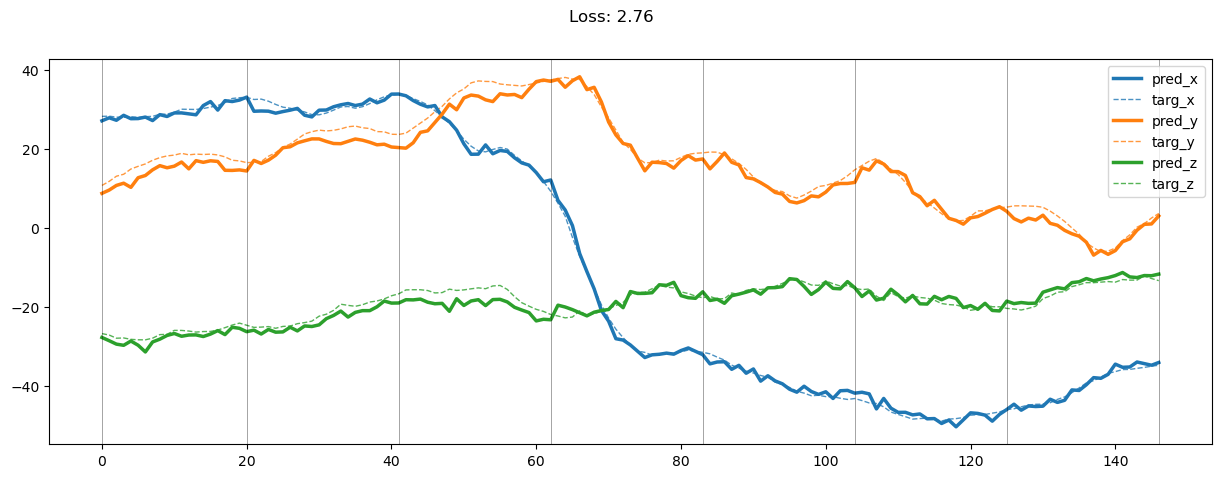

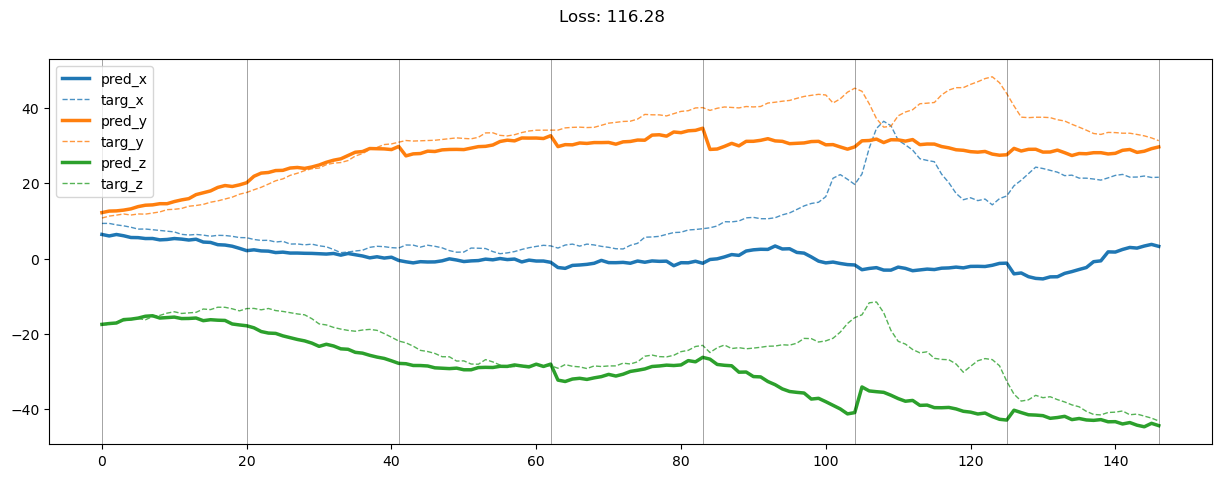

05999: train loss:  2.581, lin acc loss:  0.589, gro loss:  0.104, mag loss:  1.888
       valid loss:  69.355, lin acc loss:  0.832, gro loss:  0.072, mag loss:  68.451


In [29]:
draw = True

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_lin_acc_loss, train_gro_loss, train_mag_loss = train(train_loader, draw)
    valid_loss, valid_lin_acc_loss, valid_gro_loss, valid_mag_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, lin acc loss: {train_lin_acc_loss: 2.3f}, gro loss: {train_gro_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, lin acc loss: {valid_lin_acc_loss: 2.3f}, gro loss: {valid_gro_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}')

In [30]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data[:, :, :, 0:9].to(device)
            target_data = target_data[:, :, :, 0:9].to(device)

            # generate mag
            predict_data = model(source_data)

            # generator loss
            gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)

            results.extend(zip(predict_data[:, :, :, 6:9].detach().cpu().numpy(), target_data[:, :, :, 6:9].cpu().numpy()))
    
    return np.array(results)

In [31]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(291, 2, 7, 21, 3)


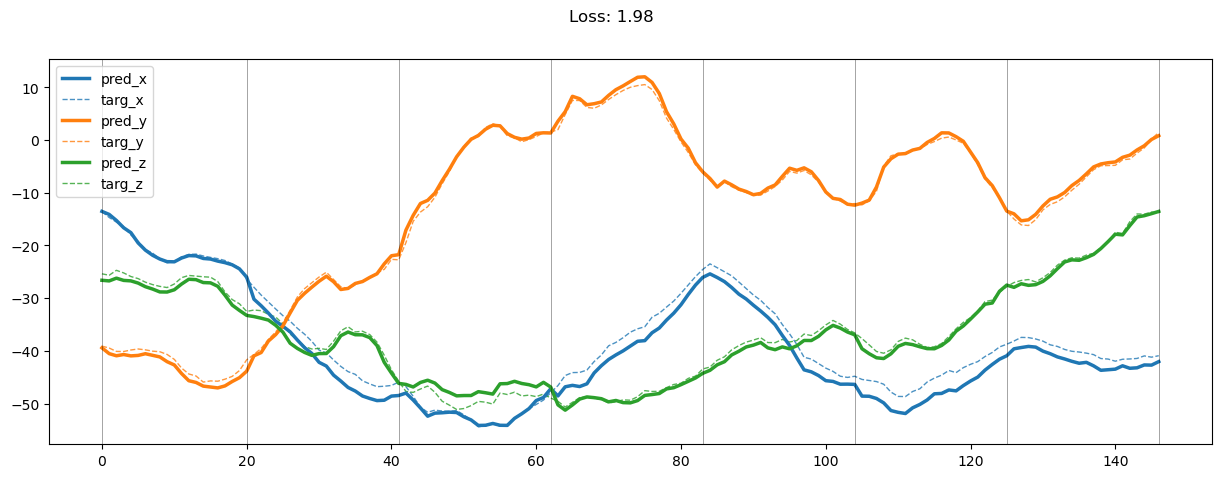

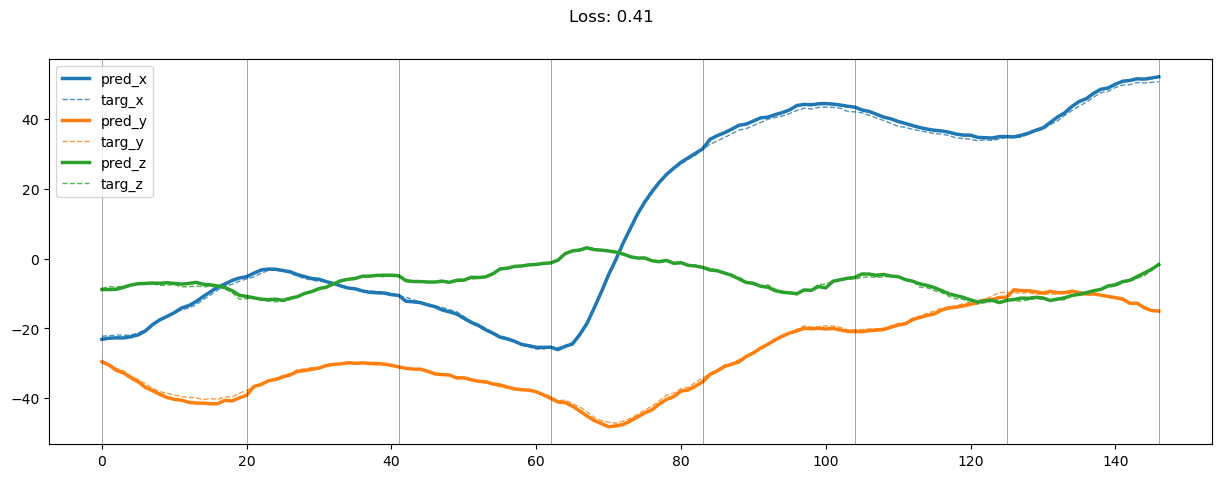

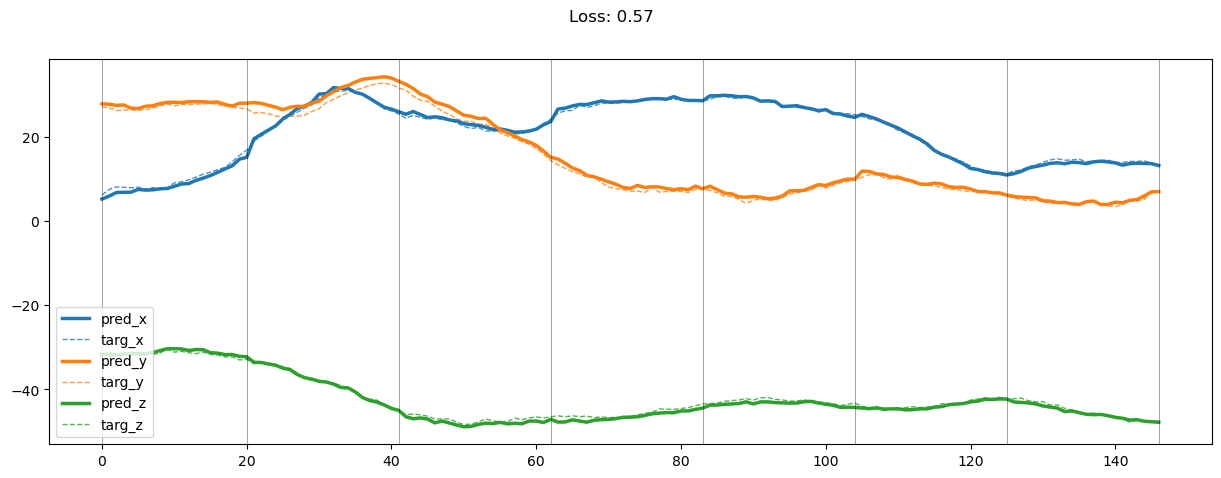

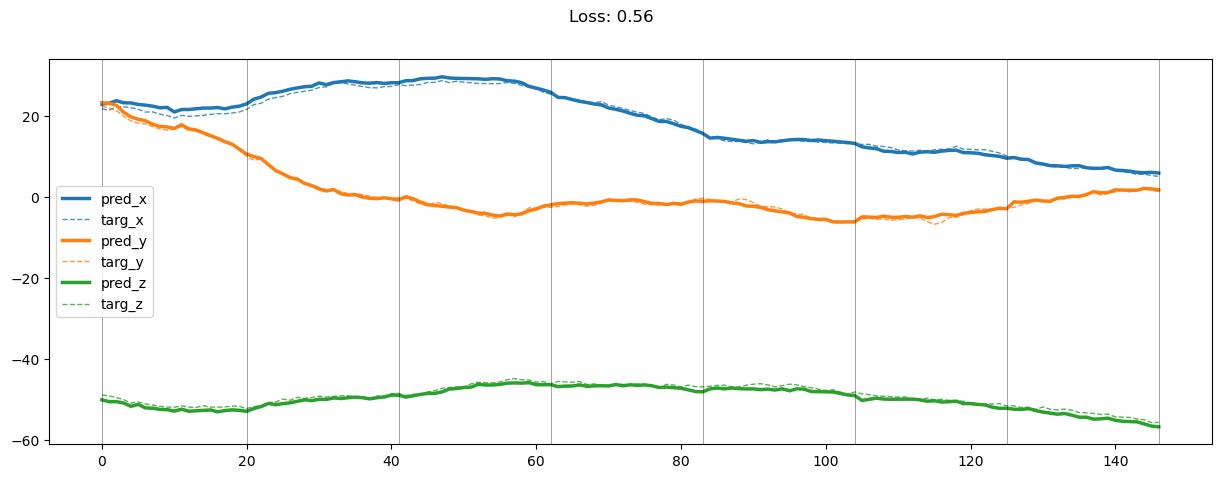

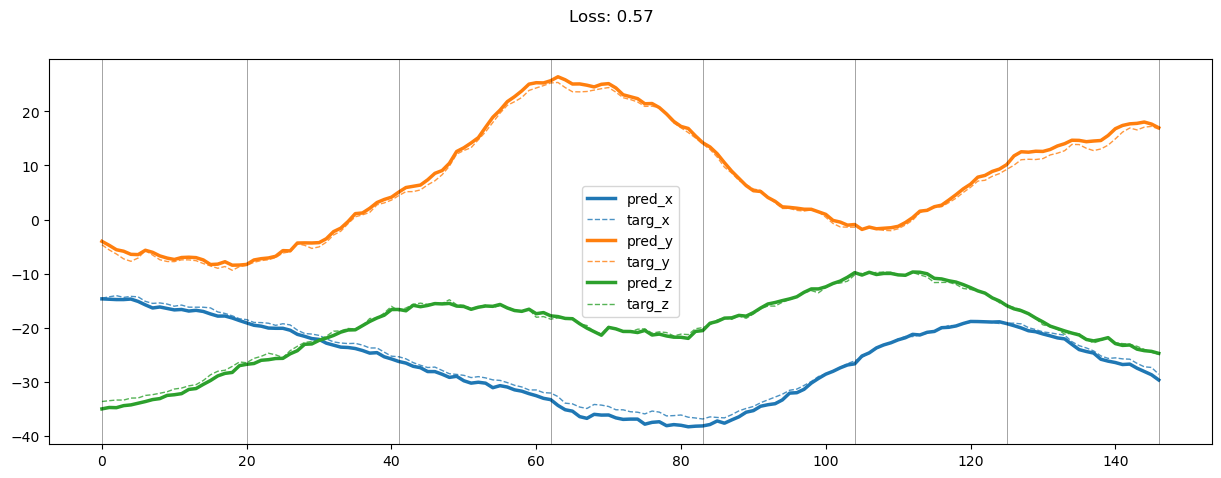

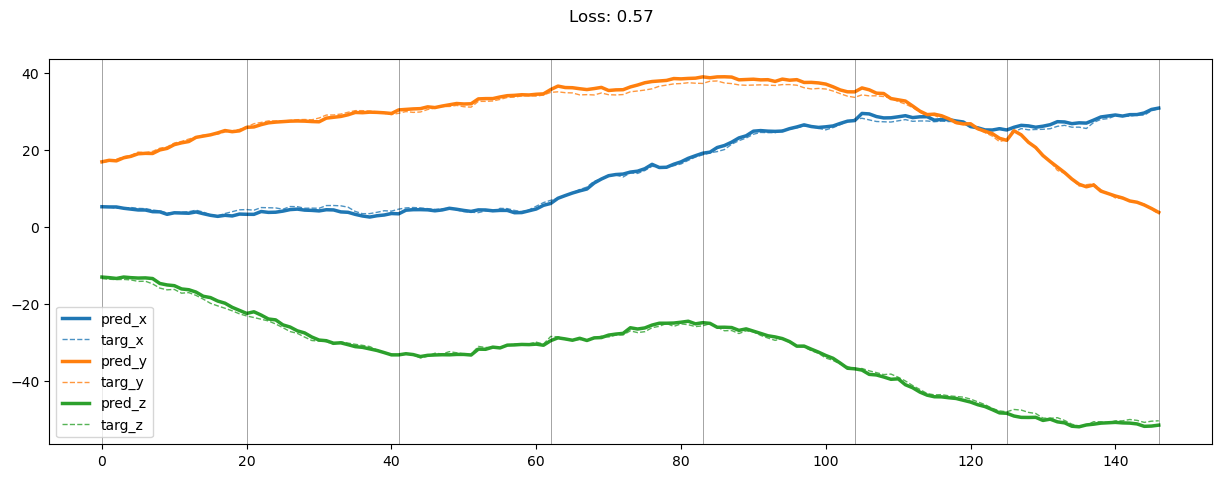

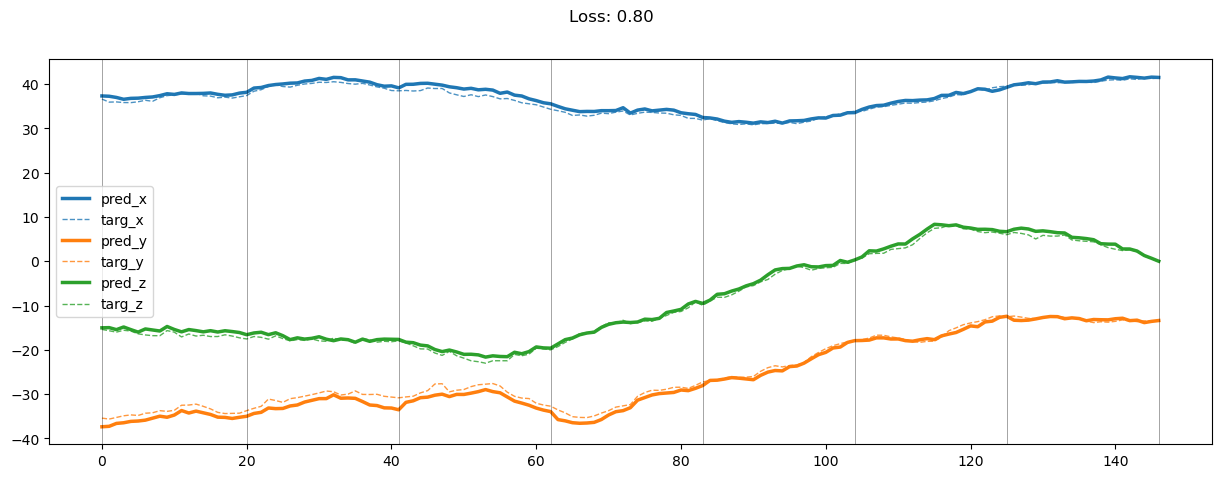

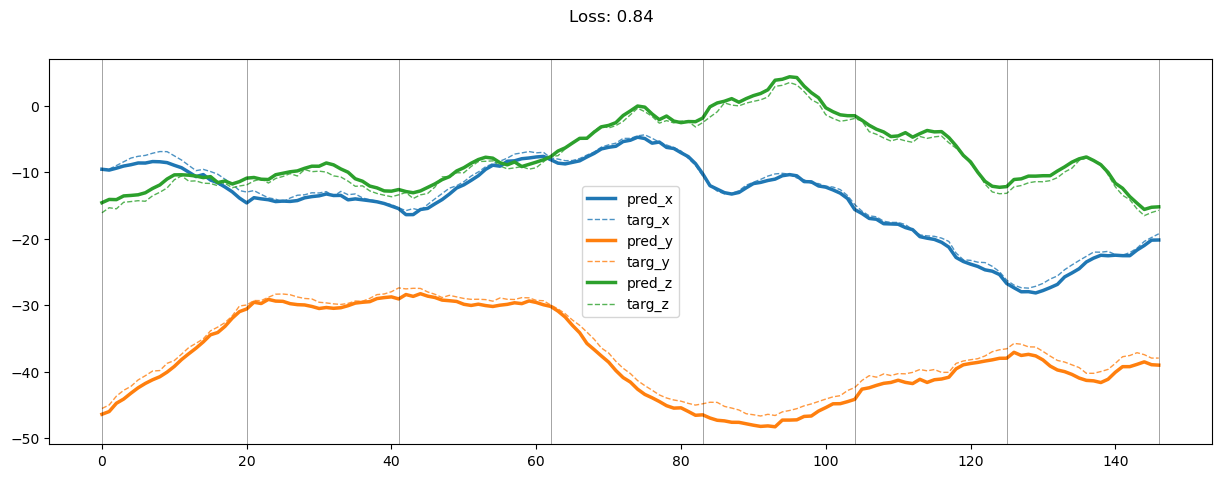

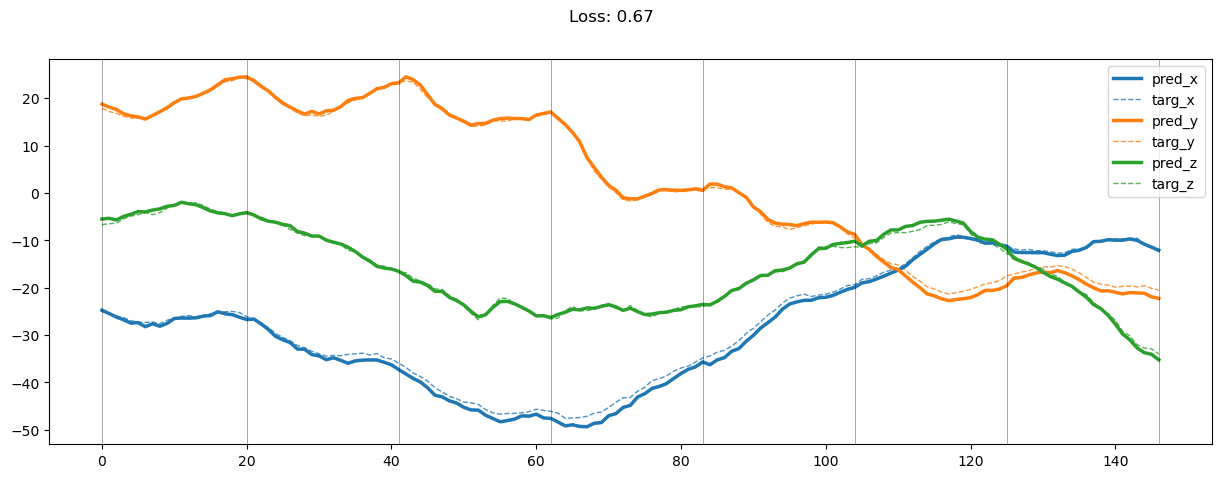

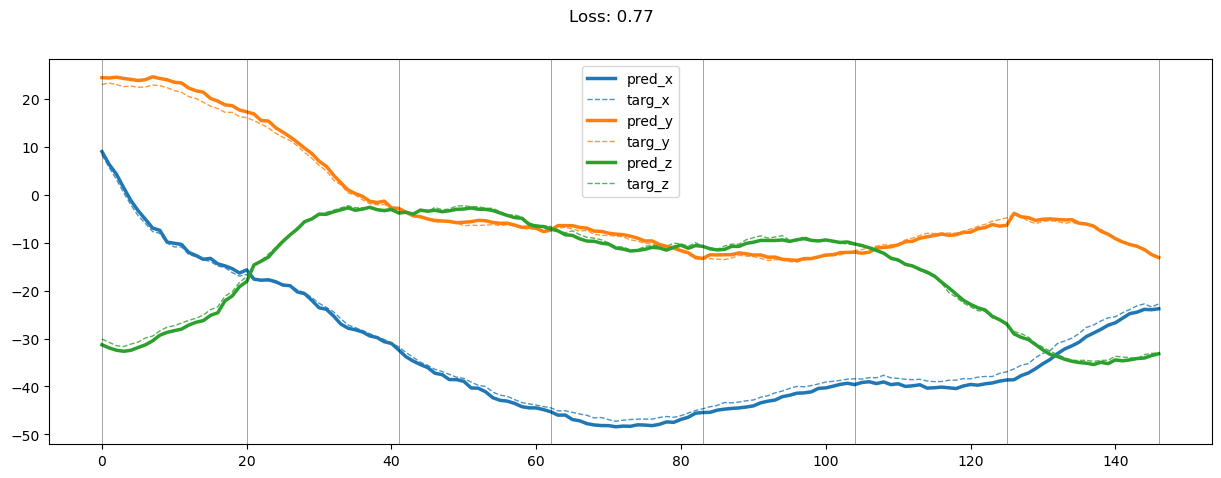

In [32]:
results = output_eval(model, train_loader)

print(results.shape)

for rs in results[::30]:
    plot_result(rs)

(73, 2, 7, 21, 3)


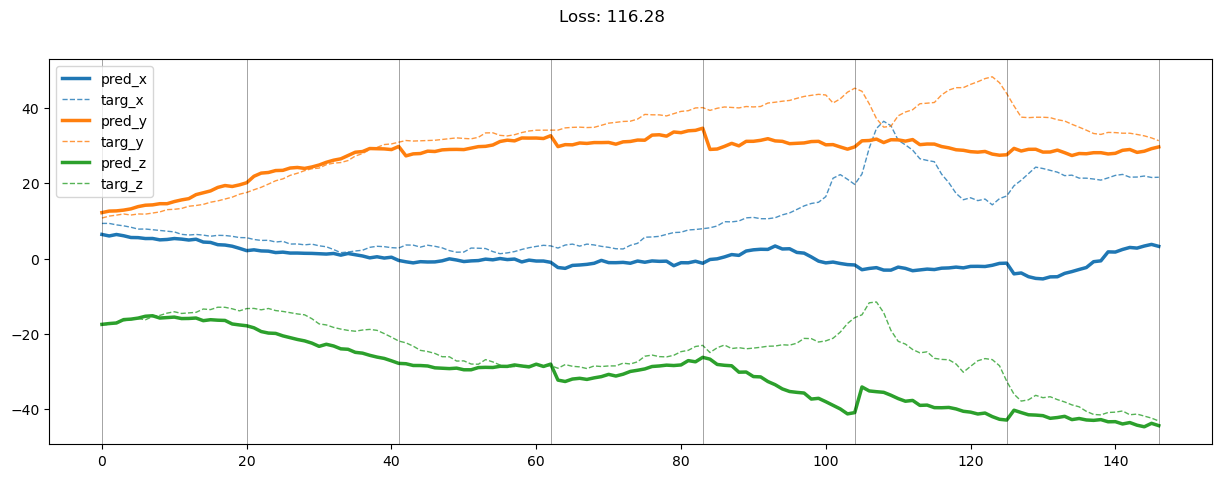

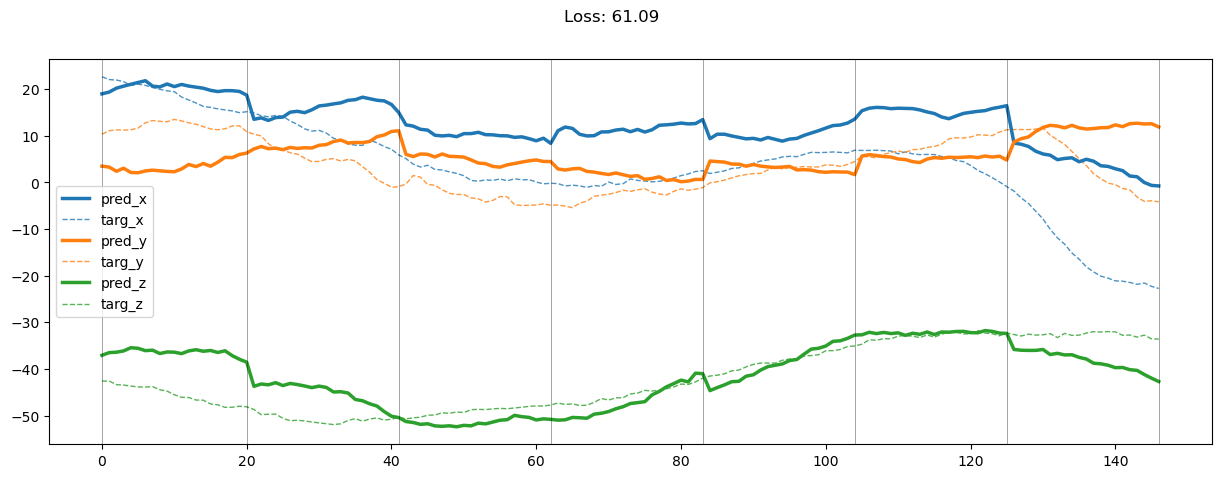

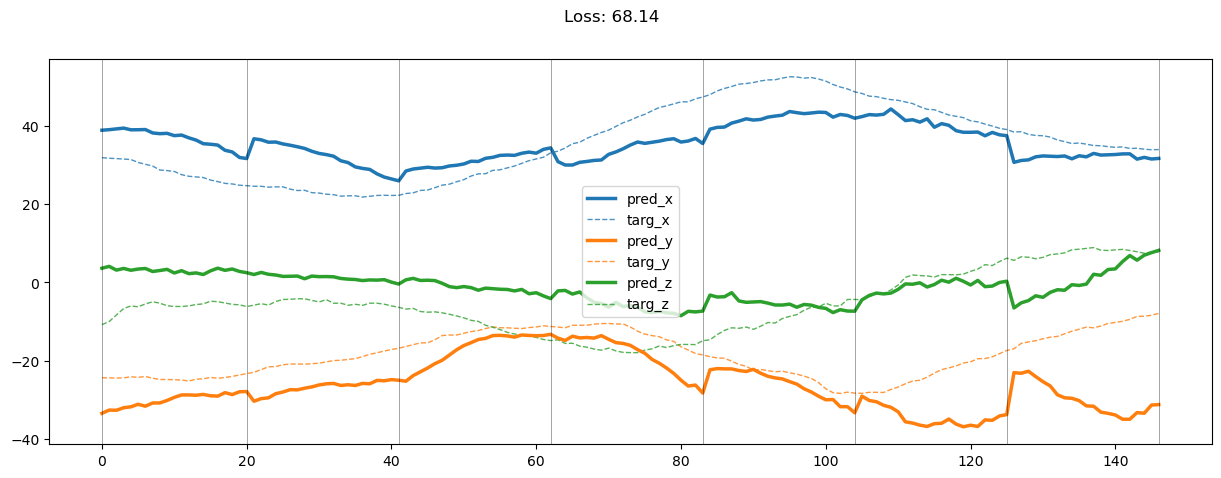

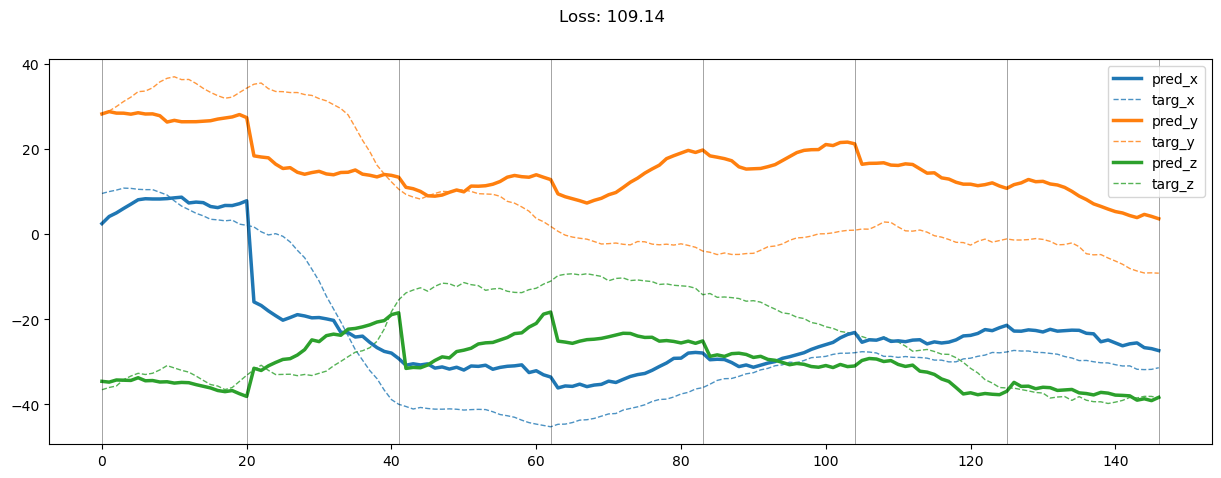

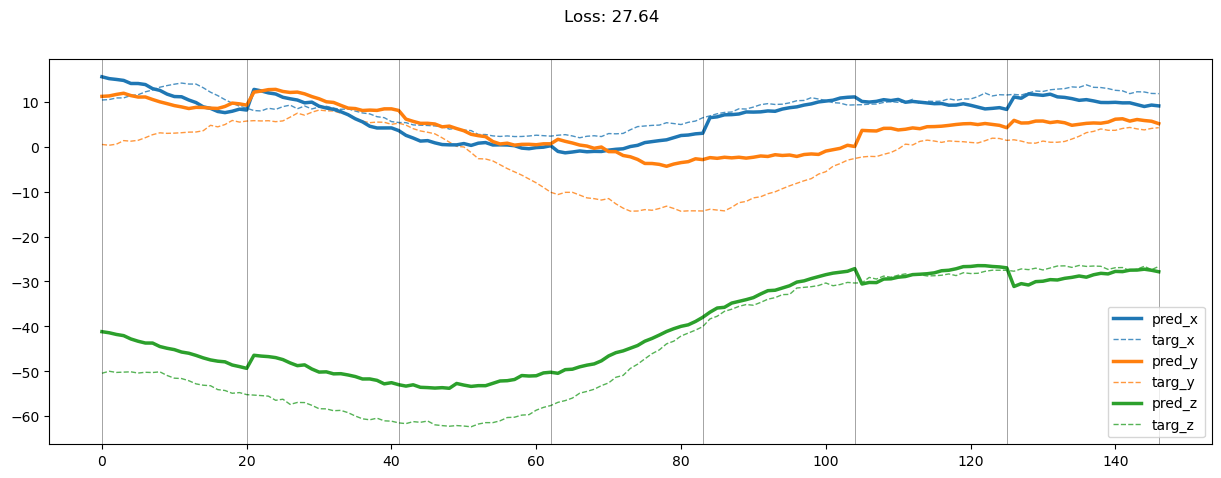

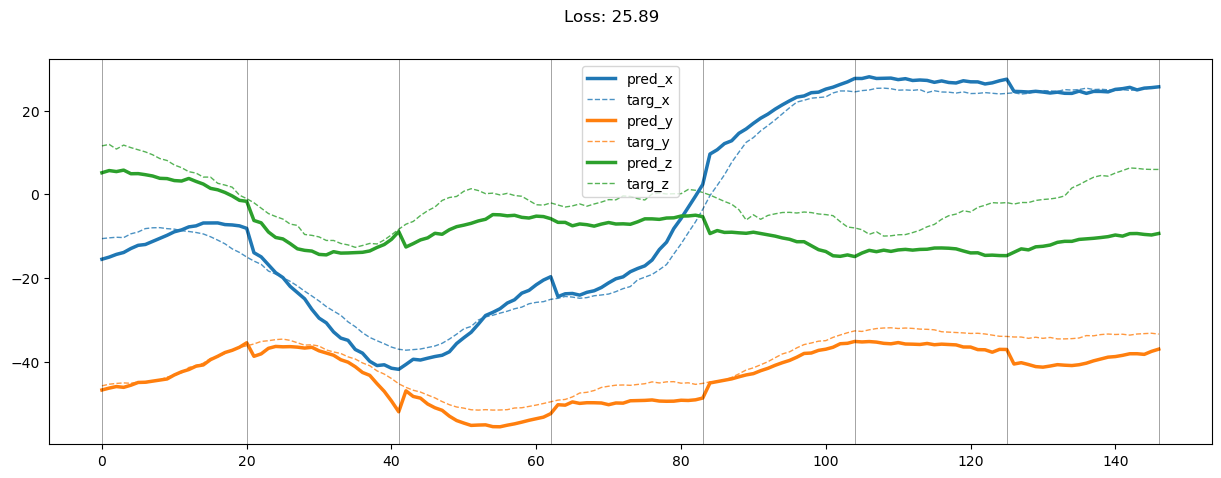

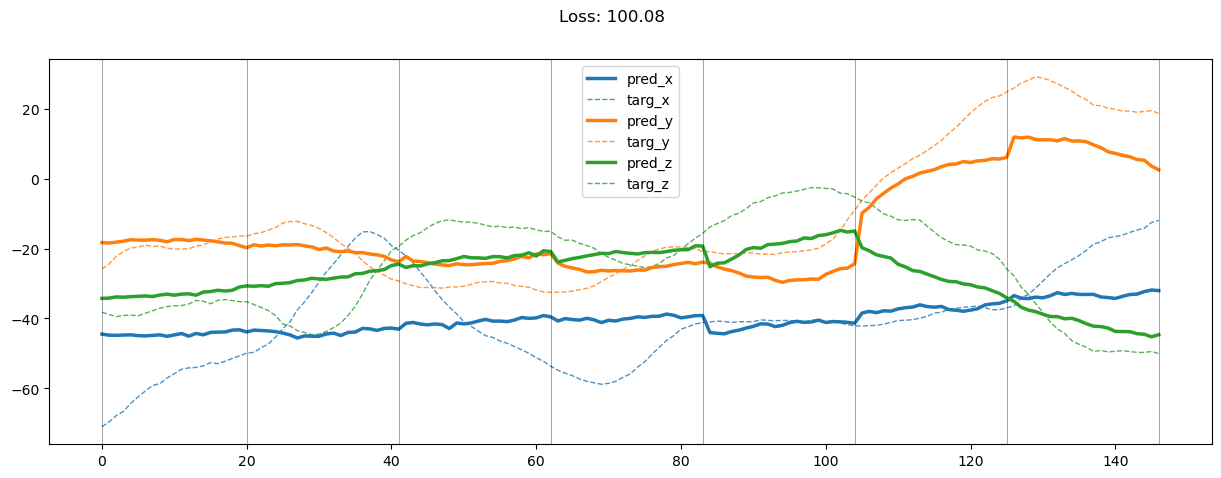

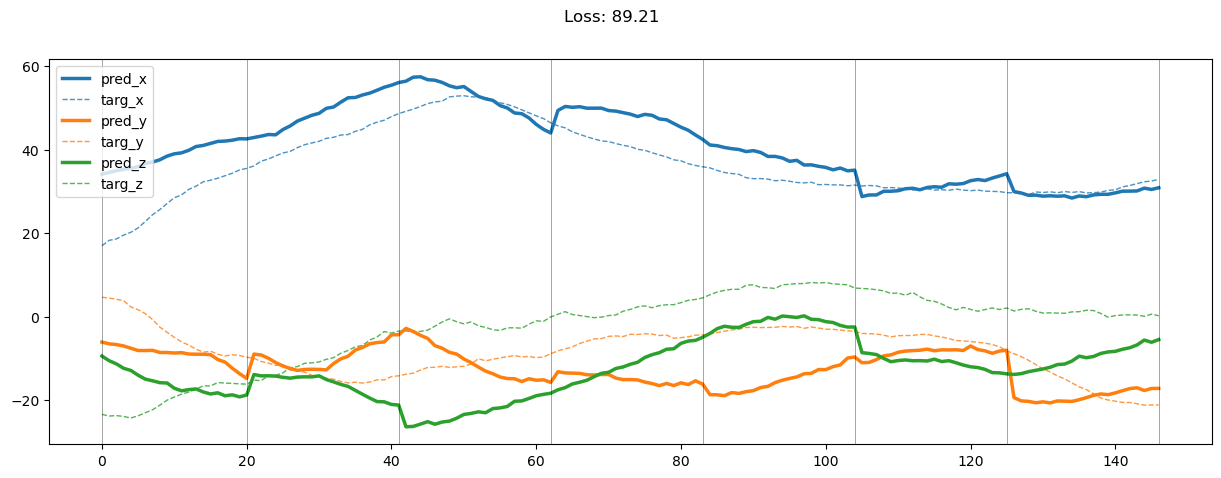

In [33]:
results = output_eval(model, valid_loader)

print(results.shape)

for rs in results[::10]:
    plot_result(rs)